In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wandb
import datetime

In [2]:
entity = "evangeorgerex"
project_name = "fwal"
api = wandb.Api()

In [3]:
results_dir = r'/home/er647/projects/feature-wise-active-learning/results'

In [4]:
# we need all the run ids for fact
# then we need to get the best_mask_1_histogram or best_mask_1_parameters from the summary for each run
# this is a histogram. We can then concatenate the histograms. Ok so first we need to know what our datastructure should be for the histograms.

In [15]:
run_ids = [
    "bfi5l6qu" , # COIL20
    "ihpfigr4" , # COIL20
    "rhrqy9bb" , # COIL20
    "sj64pl05" , # Isolet
    "dtv0wjox" , # Isolet
    "gp378vp4" , # Isolet
    "vqcdnueq" , # PBMC
    '3e7c2ala' , # PBMC
    '9qx2b2na' , # PBMC
    "b8nrupvc" , # USPS
    "rcacu3yt" , # USPS
    "swbk9dsz" , # USPS
    "sawnisk5" , # finance
    "dqq6q5ej" , # finance
    "33iwvq59" , # finance
    "ko5c4p3v" , # madelon
    "h4m5vvcm" , # madelon
    "zyuohsyk" , # madelon
    "5le875vr" , # mice_protein
    "6utw0s44" , # mice_protein
    "r46u12zd" , # mice_protein
    "n0mcba2f" , # poly_binarised_decimalised_synth
    "94j8ch8b" , # poly_binarised_decimalised_synth
    "qskac7qn" , # poly_binarised_decimalised_synth
]

In [16]:
def get_mask_data(run_ids):
    """
    Returns a pandas DataFrame with columns 'mask_value' and 'dataset'.
    
    This function retrieves the mask data for each run specified by the given run_ids. The mask data is obtained from the 'best_mask_1_parameters' key in the summary. The mask data is a list of floats, which represents the mask values. Additionally, the function also retrieves the dataset information from the configuration.
    
    Args:
        run_ids (list): A list of run IDs for which the mask data needs to be retrieved.
        
    Returns:
        pandas.DataFrame: A DataFrame containing the mask values and dataset information.
    """
    
    # Implementation goes here
    mask_data = []
    for run_id in run_ids:
        run = api.run(f"{entity}/{project_name}/{run_id}")
        mask_0 = run.summary['best_mask_0_parameters']
        mask = run.summary['best_mask_1_parameters']
        dataset = run.config['dataset']
        for i in range(len(mask)):
            mask_data.append({'feature':i, 'mask_value': mask[i], 'mask_0_value': mask_0[i], 'dataset': dataset, 'run_id': run_id})
    return pd.DataFrame(mask_data)



In [17]:
# mask can be one of 'mask_value' or 'mask_0_value'
def plot_hists(df: pd.DataFrame, how="logits", save=False,threshold_line=None, mask_0=False):
    """
    Plot histograms of mask values for different datasets.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - how (str): The type of mask values to plot. Must be one of 'logits' or 'probability'. Default is 'logits'.
    - save (bool): Whether to save the plot as an image file. Default is False.
    - bins (int): The number of bins to use for the histograms. Default is 100.
    - threshold_line (float): The threshold value to plot as a vertical line. Default is None.
    - mask_0 (bool): Whether to use the 'mask_0_value' column instead of 'mask_value'. Default is False.

    Returns:
    None
    """
    if how == "logits":
        x = 'mask_value' if not mask_0 else 'mask_0_value'
        x_label = 'Mask Value'
    elif how == "probability":
        x = 'mask_value_probability' if not mask_0 else 'mask_0_value_probability'
        x_label = 'Mask Probability'
    else:
        raise ValueError("how must be one of 'logits' or 'probability'")

    datasets = ['USPS', 'mice_protein', 'COIL20', 'Isolet', 'PBMC', 'finance', 'madelon']

    # Number of unique datasets
    num_datasets = df['dataset'].nunique()

    # Create a figure with 2 rows and 4 columns of subplots
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10), sharex=True)

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    title_map = {
        'USPS': 'USPS',
        'mice_protein': 'Mice Protein',
        'Isolet': 'Isolet',
        'madelon': 'Madelon',
        'COIL20': 'COIL20',
        'PBMC': 'PBMC',
        'finance': 'Finance'
    }
    bin_map = {
        'USPS': 75,
        'mice_protein': 40,
        'Isolet': 500,
        'madelon': 250,
        'COIL20': 500,
        'PBMC': 10000,
        'finance': 100
    }
    
    
    # Font size settings
    axis_title_font_size = 38
    axis_label_font_size = 38
    
    
    # Loop over each group and plot
    for idx, dataset in enumerate(datasets):
        group = df[df['dataset'] == dataset]
        ax = axes[idx]
        sns.histplot(data=group, x=x, bins=bin_map[dataset], kde=True, ax=ax, color='grey', edgecolor=None)
        ax.set_title(title_map[dataset], fontsize=axis_title_font_size)
        ax.set_xlabel(x_label, fontsize=axis_label_font_size)
        ax.set_ylabel('Frequency', fontsize=axis_label_font_size)
        
        if idx in [0,1,2]:
            ax.set_xlabel('')
        if idx in [1,2,3,5,6]:
            ax.set_ylabel('')
            
        if threshold_line is not None:
            ax.axvline(x=threshold_line, color='red', linestyle='--')

    # Turn off unused subplots if the number of datasets is less than the number of subplots
    for ax in axes[num_datasets:]:
        ax.axis('off')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    if save:
        plt.savefig(f'{results_dir}/{x}_histograms.pdf')
    plt.show()


In [18]:
df = get_mask_data(run_ids)
df = df[df['dataset'] !=  'poly_binarised_decimalised_synth']
# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Apply the sigmoid function to the 'mask_value' column and create a new 'probability' column
df['mask_value_probability'] = df['mask_value'].apply(sigmoid)
df['mask_0_value_probability'] = df['mask_0_value'].apply(sigmoid)

In [19]:
# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Apply the sigmoid function to the 'mask_value' column and create a new 'probability' column
df['mask_value_probability'] = df['mask_value'].apply(sigmoid)
df['mask_0_value_probability'] = df['mask_0_value'].apply(sigmoid)


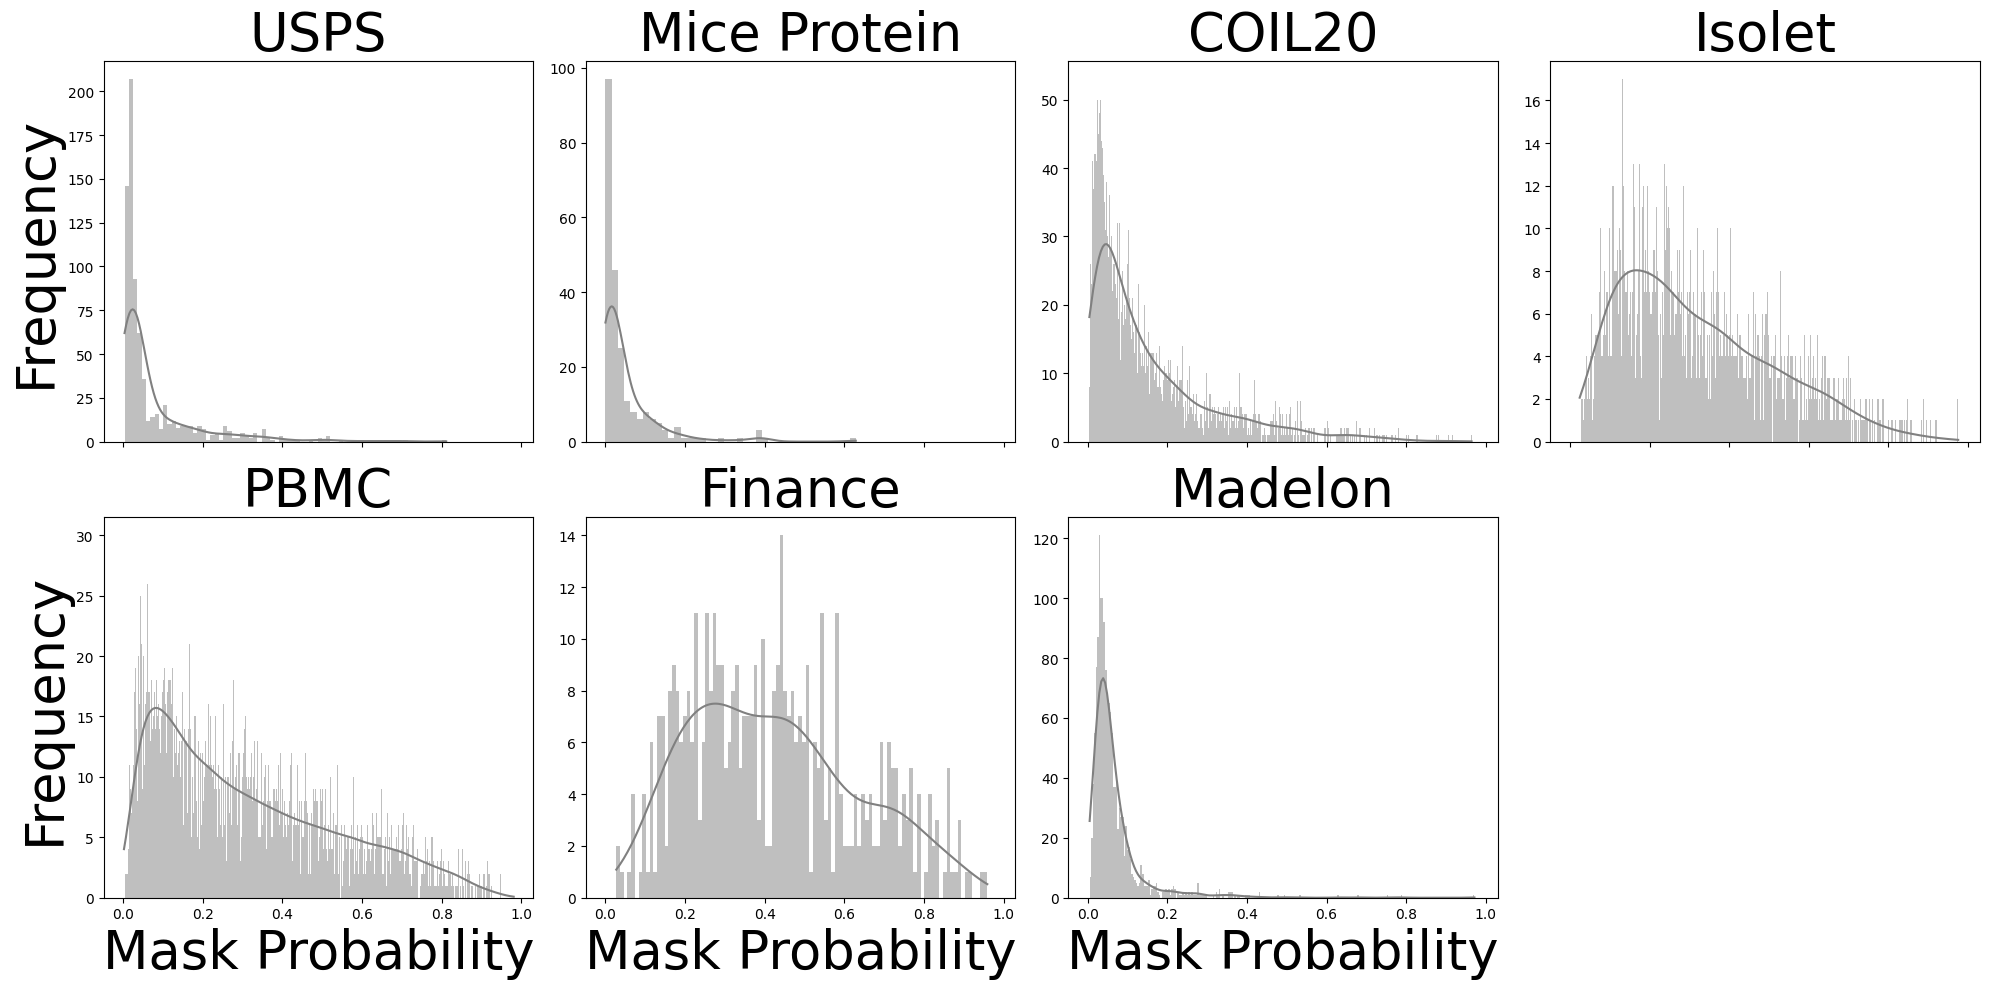

In [11]:
plot_hists(df, how = "probability", save=True, mask_0=True)

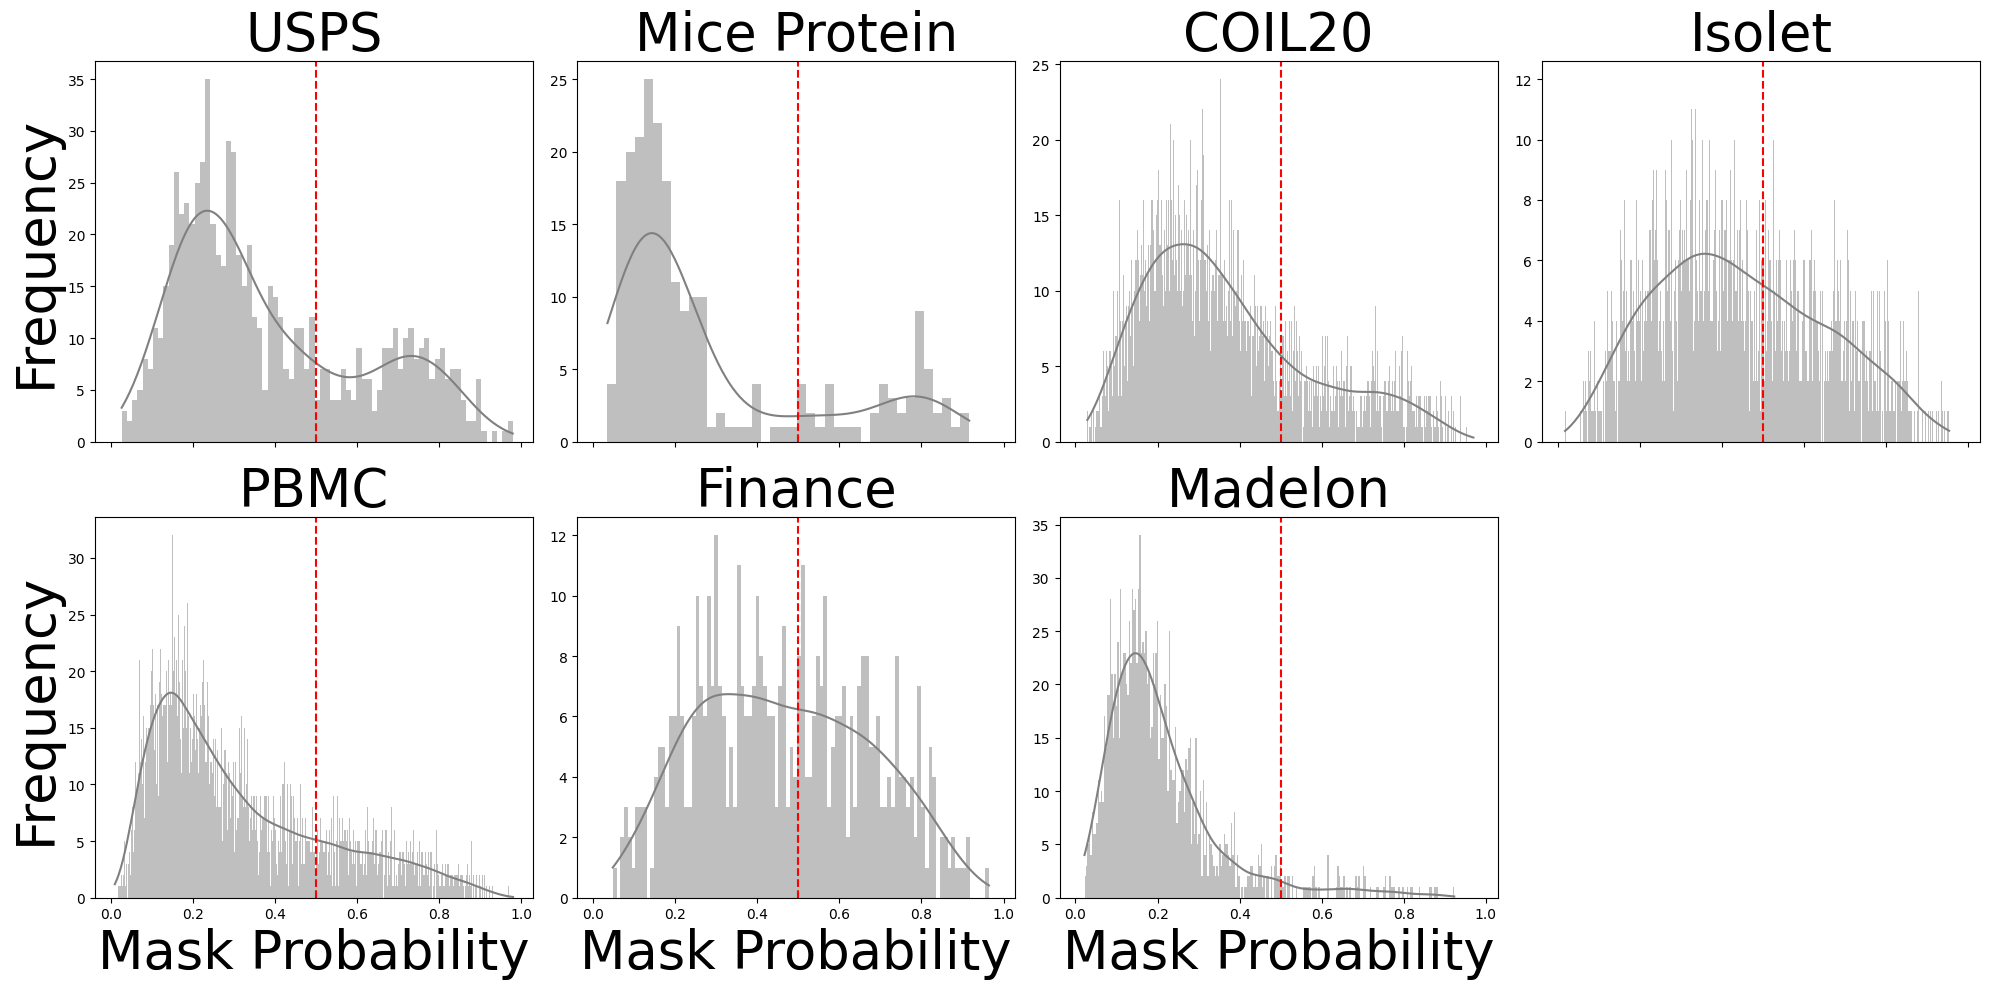

In [12]:
plot_hists(df, how = "probability", save=True, mask_0=False, threshold_line=0.5)


# Analysis utilities

In [4]:
def load_feature_importance_lasso(run):

    history = run.history()

    # Determine the maximum indices for classes and features
    max_class_index = max(int(col.split('_')[1]) for col in history.columns if 'class_' in col)
    max_feature_index = max(int(col.split('_')[-1]) for col in history.columns if 'feature' in col)

    # Initialize a 2D array of NaNs
    coef = np.full((max_class_index + 1, max_feature_index + 1), np.nan)

    # Iterate over each column and assign values to the coef array
    for col in history.columns:
        if 'class_' in col and 'feature' in col:
            parts = col.split('_')
            class_index = int(parts[1])
            feature_index = int(parts[-1])
            # Find the non-NaN value in this column
            non_nan_value = history[col].dropna().values[0]  # assuming there is exactly one non-NaN value per feature and class
            coef[class_index, feature_index] = non_nan_value

    # Now 'coef' is your reconstructed 2D array similar to 'model.coef_' in sklearn Lasso for multi-class problems
    feature_importance = np.mean(np.abs(coef), axis=0)
    return feature_importance

def get_lasso_mask_data(run_ids):
    """
    Returns a pandas DataFrame with columns 'mask_value' and 'dataset'.
    
    This function retrieves the mask data for each run specified by the given run_ids. The mask data is obtained from the 'best_mask_1_parameters' key in the summary. The mask data is a list of floats, which represents the mask values. Additionally, the function also retrieves the dataset information from the configuration.
    
    Args:
        run_ids (list): A list of run IDs for which the mask data needs to be retrieved.
        
    Returns:
        pandas.DataFrame: A DataFrame containing the mask values and dataset information.
    """
    
    # Implementation goes here
    mask_data = []
    for run_id in run_ids:
        run = api.run(f"{entity}/{project_name}/{run_id}")
        feature_importances = load_feature_importance_lasso(run)
        dataset = run.config['dataset']
        for i in range(len(feature_importances)):
            mask_data.append({'feature':i, 'feature_importance': feature_importances[i], 'dataset': dataset, 'run_id': run_id})
    return pd.DataFrame(mask_data)


In [5]:
def load_feature_importance(run):
    # Load the feature importance
    history = run.history()
    
    max_index = max(int(col.split('_')[-1]) for col in history.columns if 'feature_importances.feature' in col)
    feature_importances = np.full(max_index + 1, np.nan)

    # Iterate over each column and place the non-NaN value in the corresponding position in the array
    for col in history.columns:
        if 'feature_importances.feature' in col:
            # Extract the feature index from the column name
            feature_index = int(col.split('_')[-1])
            # Find the non-NaN value in this column
            non_nan_value = history[col].dropna().values[0]  # assuming there is exactly one non-NaN value per feature
            feature_importances[feature_index] = non_nan_value
    return feature_importances

def get_tree_mask_data(run_ids):
    """
    Returns a pandas DataFrame with columns 'mask_value' and 'dataset'.
    
    This function retrieves the mask data for each run specified by the given run_ids. The mask data is obtained from the 'best_mask_1_parameters' key in the summary. The mask data is a list of floats, which represents the mask values. Additionally, the function also retrieves the dataset information from the configuration.
    
    Args:
        run_ids (list): A list of run IDs for which the mask data needs to be retrieved.
        
    Returns:
        pandas.DataFrame: A DataFrame containing the mask values and dataset information.
    """
    
    # Implementation goes here
    mask_data = []
    for run_id in run_ids:
        run = api.run(f"{entity}/{project_name}/{run_id}")
        feature_importances = load_feature_importance(run)
        dataset = run.config['dataset']
        for i in range(len(feature_importances)):
            mask_data.append({'feature':i, 'feature_importance': feature_importances[i], 'dataset': dataset, 'run_id': run_id})
    return pd.DataFrame(mask_data)

# USPS Analysis

### fact

In [11]:
USPS_df = df[df['dataset'] == 'USPS'].copy()
USPS_df['selected'] = USPS_df['mask_value'] > 0

USPS_df['rank0'] = USPS_df['mask_0_value'].rank(method='dense', ascending=False) - 1
USPS_df['rank'] = USPS_df['mask_value'].rank(method='dense', ascending=False) - 1


In [25]:
USPS_df

,feature,mask_value,mask_0_value,dataset,run_id,mask_value_probability,mask_0_value_probability,selected,rank0,rank
70719,0,1.214305,-1.983831,USPS,b8nrupvc,0.771060,0.120911,True,145.0,65.0
70720,1,-1.646855,-4.103479,USPS,b8nrupvc,0.161534,0.016247,False,580.0,668.0
70721,2,1.492019,-1.901712,USPS,b8nrupvc,0.816381,0.129915,True,134.0,37.0
70722,3,0.825525,-2.440429,USPS,b8nrupvc,0.695408,0.080141,True,196.0,122.0
70723,4,-1.239665,-4.394748,USPS,b8nrupvc,0.224494,0.012192,False,667.0,548.0
...,...,...,...,...,...,...,...,...,...,...
71482,251,-2.685368,-4.335750,USPS,swbk9dsz,0.063842,0.012923,False,650.0,759.0
71483,252,-0.678107,-3.946650,USPS,swbk9dsz,0.336684,0.018953,False,519.0,350.0
71484,253,-2.110176,-4.765980,USPS,swbk9dsz,0.108112,0.008443,False,737.0,732.0
71485,254,1.134572,0.307576,USPS,swbk9dsz,0.756682,0.576294,True,5.0,75.0


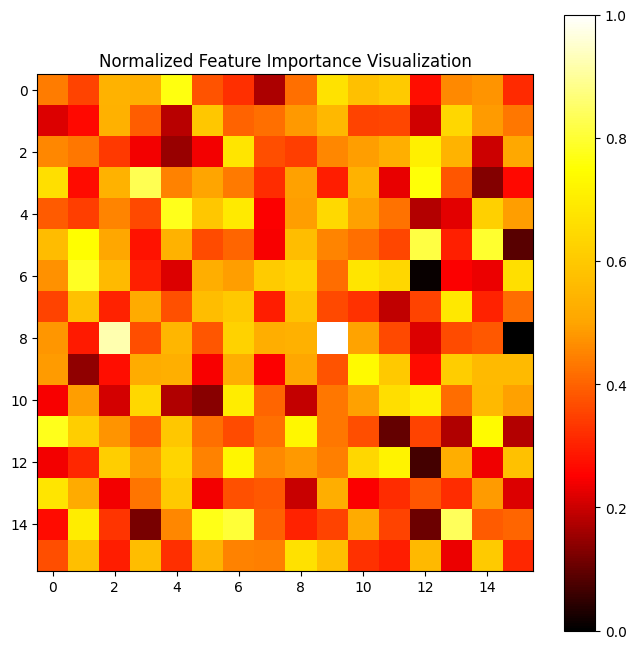

In [26]:
from matplotlib.colors import LinearSegmentedColormap

# Reshaping the feature importances to form a 32x32 array
feature_importance = USPS_df.groupby('feature')['mask_value'].mean().values.reshape((16, 16))


# feature_importance = USPS_df[USPS_df['run_id'] == 'rhrqy9bb']['mask_value'].values.reshape((16, 16))


# Custom color map from black to white passing through red, orange, and yellow
colors = ["black", "red", "orange", "yellow", "white"]


# Adjusting the color bin transitions to cover the entire range from 0 to 1
n_bins = [0, 0.25, 0.5, 0.75, 1]  # Updated limits for each color
cmap = LinearSegmentedColormap.from_list("custom", list(zip(n_bins, colors)))

# Normalizing the feature importance data to range from 0 to 1
normalized_importance = (feature_importance - feature_importance.min()) / (feature_importance.max() - feature_importance.min())

# Re-plotting the image
plt.figure(figsize=(8, 8))
plt.imshow(normalized_importance, cmap=cmap, interpolation='nearest')
plt.colorbar()
plt.title('Normalized Feature Importance Visualization')
plt.show()


In [28]:
USPS_df

,feature,mask_value,mask_0_value,dataset,run_id,mask_value_probability,mask_0_value_probability,selected,rank0,rank
70719,0,1.214305,-1.983831,USPS,b8nrupvc,0.771060,0.120911,True,145.0,65.0
70720,1,-1.646855,-4.103479,USPS,b8nrupvc,0.161534,0.016247,False,580.0,668.0
70721,2,1.492019,-1.901712,USPS,b8nrupvc,0.816381,0.129915,True,134.0,37.0
70722,3,0.825525,-2.440429,USPS,b8nrupvc,0.695408,0.080141,True,196.0,122.0
70723,4,-1.239665,-4.394748,USPS,b8nrupvc,0.224494,0.012192,False,667.0,548.0
...,...,...,...,...,...,...,...,...,...,...
71482,251,-2.685368,-4.335750,USPS,swbk9dsz,0.063842,0.012923,False,650.0,759.0
71483,252,-0.678107,-3.946650,USPS,swbk9dsz,0.336684,0.018953,False,519.0,350.0
71484,253,-2.110176,-4.765980,USPS,swbk9dsz,0.108112,0.008443,False,737.0,732.0
71485,254,1.134572,0.307576,USPS,swbk9dsz,0.756682,0.576294,True,5.0,75.0


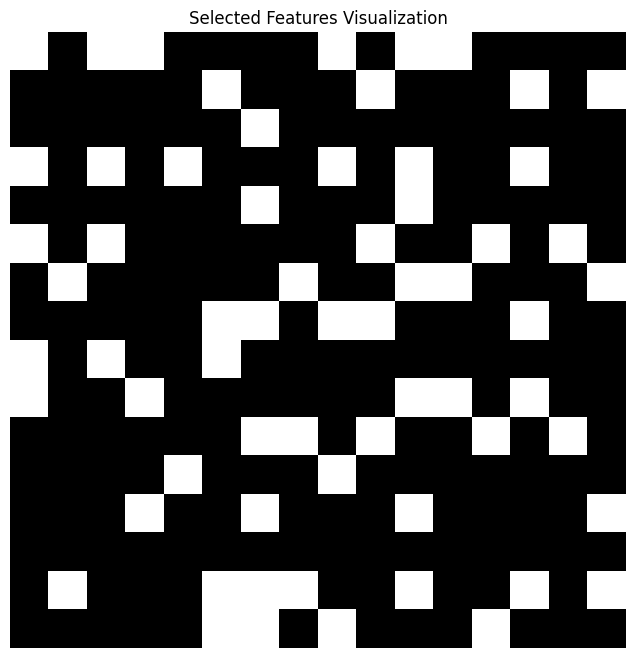

In [30]:
# Reshaping the 'selected' values into a 32x32 array
selected_array = USPS_df[USPS_df['run_id'] == 'b8nrupvc']['selected'].values.reshape((16, 16))

# Convert boolean 'True' to 1 and 'False' to 0 for visualization
selected_numeric = selected_array.astype(int)

# Plotting the image
plt.figure(figsize=(8, 8))
plt.imshow(selected_numeric, cmap='gray', interpolation='nearest')
plt.title('Selected Features Visualization')
plt.axis('off')  # Turn off axis labels
plt.show()

# COIL20 analysis

### fact

In [16]:
coil20_df = df[df['dataset'] == 'COIL20'].copy()
coil20_df['selected'] = coil20_df['mask_value'] > 0

coil20_df['rank0'] = coil20_df['mask_0_value'].rank(method='dense', ascending=False) - 1
coil20_df['rank'] = coil20_df['mask_value'].rank(method='dense', ascending=False) - 1


In [17]:
coil20_df

,feature,mask_value,mask_0_value,dataset,run_id,mask_value_probability,mask_0_value_probability,selected,rank0,rank
0,0,-1.481845,-2.756537,COIL20,bfi5l6qu,0.185149,0.059719,False,2002.0,2530.0
1,1,0.535153,0.315952,COIL20,bfi5l6qu,0.630684,0.578337,True,92.0,424.0
2,2,0.905044,-1.425529,COIL20,bfi5l6qu,0.711985,0.193796,True,867.0,289.0
3,3,-1.211367,-2.589063,COIL20,bfi5l6qu,0.229459,0.069846,False,1866.0,2222.0
4,4,-1.129280,-2.840790,COIL20,bfi5l6qu,0.244294,0.055159,False,2073.0,2108.0
...,...,...,...,...,...,...,...,...,...,...
3067,1019,-0.809402,-3.109273,COIL20,rhrqy9bb,0.308018,0.042726,False,2281.0,1664.0
3068,1020,-2.015201,-4.425174,COIL20,rhrqy9bb,0.117616,0.011830,False,2974.0,2881.0
3069,1021,-0.917660,-2.431021,COIL20,rhrqy9bb,0.285435,0.080838,False,1722.0,1825.0
3070,1022,-2.034261,-2.690947,COIL20,rhrqy9bb,0.115652,0.063510,False,1946.0,2892.0


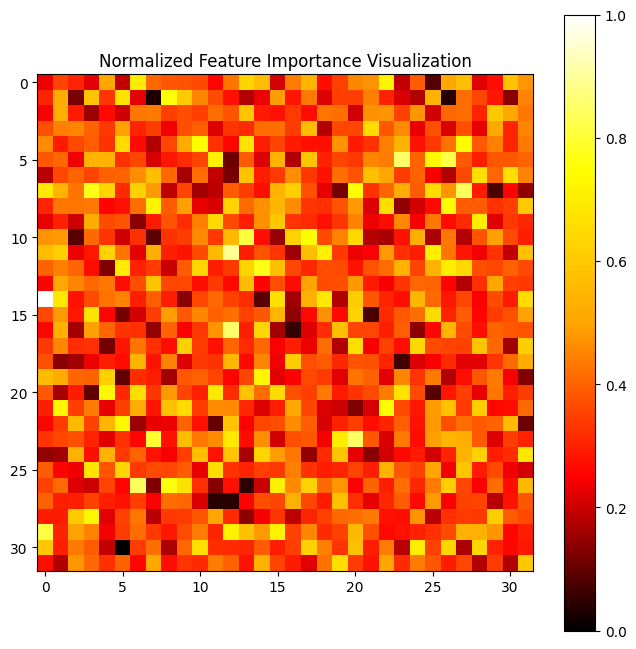

In [22]:
from matplotlib.colors import LinearSegmentedColormap

# Reshaping the feature importances to form a 32x32 array
# feature_importance = coil20_df.groupby('feature')['mask_value'].mean().values.reshape((32, 32))


feature_importance = coil20_df[coil20_df['run_id'] == 'rhrqy9bb']['mask_value'].values.reshape((32, 32))


# Custom color map from black to white passing through red, orange, and yellow
colors = ["black", "red", "orange", "yellow", "white"]


# Adjusting the color bin transitions to cover the entire range from 0 to 1
n_bins = [0, 0.25, 0.5, 0.75, 1]  # Updated limits for each color
cmap = LinearSegmentedColormap.from_list("custom", list(zip(n_bins, colors)))

# Normalizing the feature importance data to range from 0 to 1
normalized_importance = (feature_importance - feature_importance.min()) / (feature_importance.max() - feature_importance.min())

# Re-plotting the image
plt.figure(figsize=(8, 8))
plt.imshow(normalized_importance, cmap=cmap, interpolation='nearest')
plt.colorbar()
plt.title('Normalized Feature Importance Visualization')
plt.show()


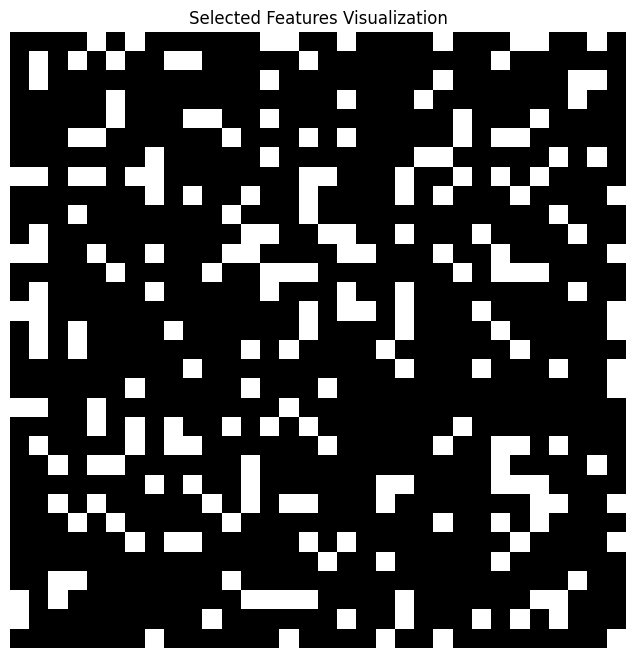

In [31]:
selected_array = coil20_df[coil20_df['run_id'] == 'rhrqy9bb']['selected'].values.reshape((32, 32))

# Convert boolean 'True' to 1 and 'False' to 0 for visualization
selected_numeric = selected_array.astype(int)

# Plotting the image
plt.figure(figsize=(8, 8))
plt.imshow(selected_numeric, cmap='gray', interpolation='nearest')
plt.title('Selected Features Visualization')
plt.axis('off')  # Turn off axis labels
plt.show()

# PBMC analysis

### fact

In [115]:
pbmc_df = df[df['dataset'] == 'PBMC']

In [116]:
# 'S100A4': 1391, # majority of time
# 'IL32': 16433, # always
# 'DUSP1': 6643 # majority of time
core_pbmc = [1391, 16433, 6643]

In [117]:
pbmc_df['selected'] = pbmc_df['mask_value'] > 0

/tmp/ipykernel_3312204/233902237.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbmc_df['selected'] = pbmc_df['mask_value'] > 0


In [123]:
# pbmc_df['rank0'] = pbmc_df['mask_0_value'].rank(method='dense', ascending=False) - 1
# pbmc_df['rank'] = pbmc_df['mask_value'].rank(method='dense', ascending=False) - 1

pbmc_df['rank'] = pbmc_df.groupby('run_id')['mask_value'].rank(ascending=False, method='min') - 1



/tmp/ipykernel_3312204/633267430.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbmc_df['rank'] = pbmc_df.groupby('run_id')['mask_value'].rank(ascending=False, method='min') - 1


In [125]:
pbmc_df['selected'] = pbmc_df['mask_value'] > 0

/tmp/ipykernel_3312204/233902237.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbmc_df['selected'] = pbmc_df['mask_value'] > 0


In [126]:
pbmc_df.groupby('run_id')['selected'].sum()


run_id
3e7c2ala     1372
9qx2b2na     1592
vqcdnueq    10540
Name: selected, dtype: int64

### lasso

In [120]:
lasso_pbmc = [
    'wns0vfsv',
    'pf3zov6p',
    'tfcohywp'
]
lasso_df = get_lasso_mask_data(lasso_pbmc)

In [127]:
lasso_df['rank'] = lasso_df.groupby('run_id')['feature_importance'].rank(ascending=False, method='min') - 1
lasso_df['selected'] = (lasso_df['rank'] < 1500) #& xgb_df['is_core']

### rf

In [129]:
rf_pbmc = [
    'gazly416',
    'wdm15edn',
    'l6o39cmv'
]
rf_df = get_tree_mask_data(rf_pbmc)


In [130]:
rf_df['rank'] = rf_df.groupby('run_id')['feature_importance'].rank(ascending=False, method='min') - 1
rf_df['selected'] = (rf_df['rank'] < 1500) #& xgb_df['is_core']

### xgb

In [131]:
xgb_pbmc = [
    'j3q3ue8i',
    '6hpzi11o',
    'qjkk5v8v'
]
xgb_df = get_tree_mask_data(xgb_pbmc)


In [132]:
xgb_df['rank'] = xgb_df.groupby('run_id')['feature_importance'].rank(ascending=False, method='min') - 1
xgb_df['selected'] = (xgb_df['rank'] < 1500) #& xgb_df['is_core']

## Plot PBMC

In [133]:
xgb_df['is_core'] = xgb_df['feature'].isin(core_pbmc)
xgb_df['model'] = 'XGBoost'
rf_df['is_core'] = rf_df['feature'].isin(core_pbmc)
rf_df['model'] = 'Rand. Forest'
lasso_df['is_core'] = lasso_df['feature'].isin(core_pbmc)
lasso_df['model'] = 'Lasso'
pbmc_df['is_core'] = pbmc_df['feature'].isin(core_pbmc)
pbmc_df['model'] = 'F-Act (Ours)'


/tmp/ipykernel_3312204/3663038810.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbmc_df['is_core'] = pbmc_df['feature'].isin(core_pbmc)
/tmp/ipykernel_3312204/3663038810.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbmc_df['model'] = 'F-Act (Ours)'


In [141]:
analysis_df = pd.concat([xgb_df, rf_df, lasso_df, pbmc_df])

# change the names of these features:

# 'S100A4': 1391, # majority of time
# 'IL32': 16433, # always
# 'DUSP1': 6643 # majority of time




/tmp/ipykernel_3312204/407723821.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  core_df['feature'] = core_df['feature'].replace({1391: 'S100A4', 16433: 'IL32', 6643: 'DUSP1'})


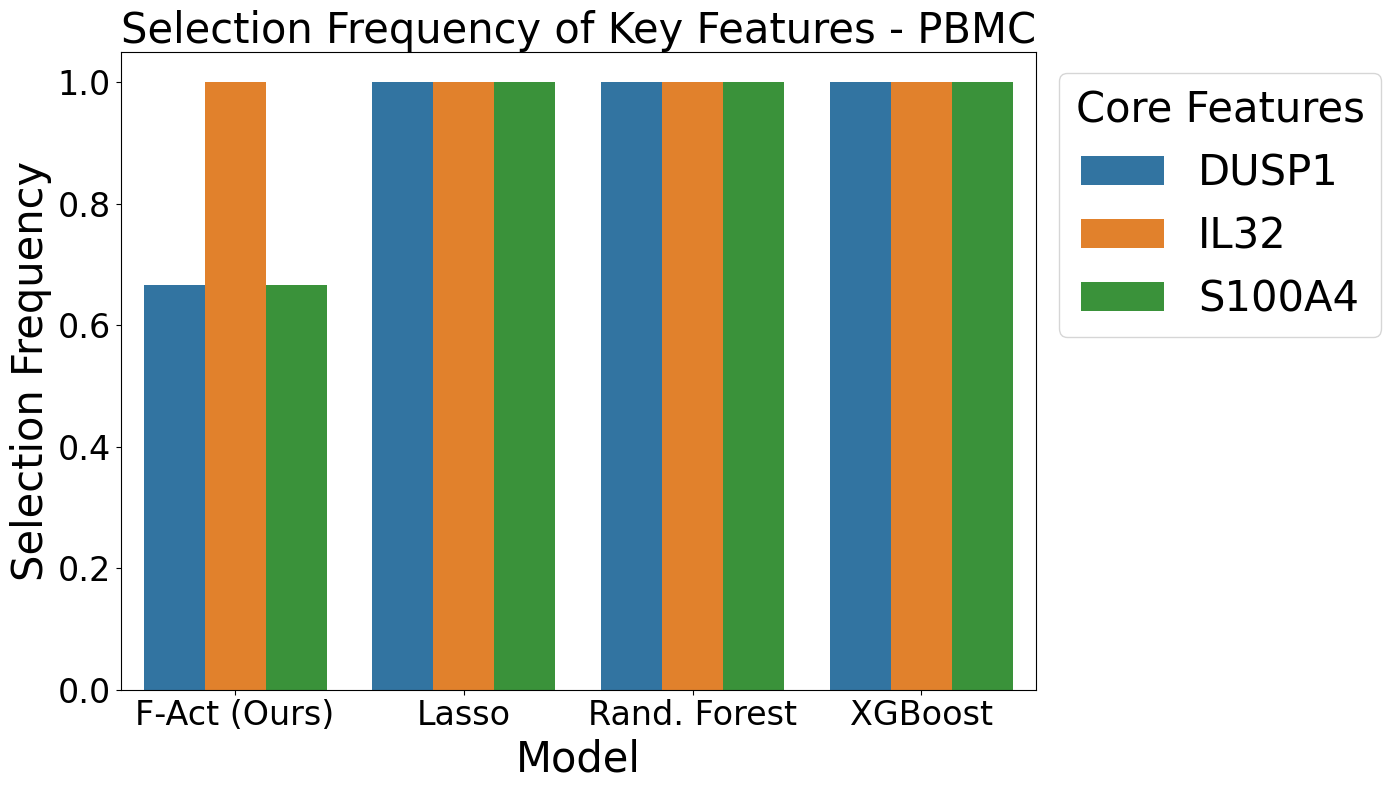

In [142]:

# Filter the DataFrame for core and dependent features
core_df = analysis_df[analysis_df['feature'].isin(core_pbmc)]

core_df['feature'] = core_df['feature'].replace({1391: 'S100A4', 16433: 'IL32', 6643: 'DUSP1'})

# Group by 'model' and 'feature' and calculate the selection frequency
core_freq = core_df.groupby(['model', 'feature'])['selected'].mean().reset_index()

# Create a figure with 2 subplots
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))  # Increased figure size

# Plot the selection frequency of core features
sns.barplot(data=core_freq, x='model', y='selected', hue='feature', ax=axes)
axes.set_title('Selection Frequency of Key Features - PBMC', fontsize=30)
axes.set_xlabel('Model', fontsize=30)
axes.set_ylabel('Selection Frequency', fontsize=30)
axes.tick_params(axis='both', labelsize=24)

axes.legend(
    title='Core Features', fontsize=30, title_fontsize=30, loc='upper right', bbox_to_anchor=(1.4, 1))

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure if required
plt.savefig(f'{results_dir}/PBMC_core_selection_frequency.pdf')

plt.show()

# Madelon analysis

## get madelon run ids for baselines

### Lasso

In [12]:
lasso_runs = [
    "2j5c9lxu",
    "k88mir2w",
    "dwxmsim1",
    "gt7tyeln",
    "70kvvbze",
    "2ptd0x5l",
    "wns0vfsv",
    "pf3zov6p",
    "tfcohywp",
    "sg718c2e",
    "xceejtd2",
    "ol6n5ujj",
    "vf369m2r",
    "qj04zf76",
    "rvzko54o",
    "wfz51c2g",
    "u8ir7re8",
    "umceu31l",
    "bkbz6gaj",
    "yugvcdf8",
    "uso6laas",
    "h0oo4eyt",
    "90w4sgar",
    "ls7yxzfh"
]

In [13]:

for run_id in lasso_runs:
    run = api.run(f"{entity}/{project_name}/{run_id}")
    dataset = run.config['dataset']
    if dataset =='madelon':
        print(run_id)

wfz51c2g
u8ir7re8
umceu31l


In [14]:
for run_id in lasso_runs:
    run = api.run(f"{entity}/{project_name}/{run_id}")
    dataset = run.config['dataset']
    if dataset =='PBMC':
        print(run_id)

wns0vfsv
pf3zov6p
tfcohywp


In [143]:
lasso_run_ids = [
    'wfz51c2g',
'u8ir7re8',
'umceu31l',
]
lasso_df = get_lasso_mask_data(lasso_run_ids)

In [144]:
lasso_df['rank'] = lasso_df.groupby('run_id')['feature_importance'].rank(ascending=False, method='min') - 1
lasso_df['selected'] = (lasso_df['rank'] < 20) #& xgb_df['is_core']

In [39]:
lasso_df

,feature,feature_importance,dataset,run_id,rank,selected
0,0,0.078580,madelon,wfz51c2g,260.0,False
1,1,0.075310,madelon,wfz51c2g,277.0,False
2,2,0.002056,madelon,wfz51c2g,494.0,False
3,3,0.075352,madelon,wfz51c2g,276.0,False
4,4,0.206576,madelon,wfz51c2g,66.0,False
...,...,...,...,...,...,...
1495,495,0.117618,madelon,umceu31l,181.0,False
1496,496,0.150012,madelon,umceu31l,125.0,False
1497,497,0.256204,madelon,umceu31l,29.0,False
1498,498,0.135802,madelon,umceu31l,147.0,False


In [89]:
average_rank(lasso_df, core)


65.0

In [90]:
average_rank(lasso_df, dependent)


13.800000000000002

### RF

In [17]:
rf_runs = [
    "9on5gumd",
    "bik140ln",
    "kbdmric0",
    "azfgf16o",
    "wfnwq2bf",
    "a0o0wjqb",
    "gazly416",
    "wdm15edn",
    "l6o39cmv",
    "klbot3sc",
    "72ooqt3p",
    "u1wd0lw7",
    "o6s1ms09",
    "zq7pcumg",
    "n2wqtr1t",
    "lxdmwbh9",
    "0achv76s",
    "oht38v7i",
    "rkv79ddl",
    "c7ow7eai",
    "vpyra7bg",
    "o6u8t6sh",
    "3frw0uoc",
    "x4cnxp9u"
]


In [18]:

for run_id in rf_runs:
    run = api.run(f"{entity}/{project_name}/{run_id}")
    dataset = run.config['dataset']
    if dataset =='madelon':
        print(run_id)

lxdmwbh9
0achv76s
oht38v7i


In [19]:

for run_id in rf_runs:
    run = api.run(f"{entity}/{project_name}/{run_id}")
    dataset = run.config['dataset']
    if dataset =='PBMC':
        print(run_id)

gazly416
wdm15edn
l6o39cmv


In [145]:
rf_ids = [
    "lxdmwbh9",
    "0achv76s",
    "oht38v7i",
]

rf_df = get_tree_mask_data(rf_ids)


In [146]:
rf_df['rank'] = rf_df.groupby('run_id')['feature_importance'].rank(ascending=False, method='min') - 1
rf_df['selected'] = (rf_df['rank'] < 20) #& xgb_df['is_core']

In [79]:
def average_rank(df, core_features):
    """
    Calculate the average rank of the specified core features in a DataFrame grouped by run_id.

    Args:
    df (pd.DataFrame): The DataFrame containing 'feature', 'feature_importance', and 'run_id'.
    core_features (list): List of features for which to calculate the average rank.

    Returns:
    float: The average rank of the core features across all runs.
    """
    # Group the DataFrame by 'run_id' and apply the ranking within each group
    df['rank'] = df.groupby('run_id')['feature_importance'].rank(ascending=False, method='min') - 1
    
    # Filter the DataFrame for core features
    core_df = df[df['feature'].isin(core_features)]
    
    # Group by 'run_id' and calculate the average rank, then average these averages if multiple run_ids are involved
    average_ranks = core_df.groupby('run_id')['rank'].mean()
    
    return average_ranks.mean()

import pandas as pd

def average_top_20_features(df, core_features):
    """
    Calculate the average number of specified core features ranked in the top 20 by feature importance, averaged across run_ids.

    Args:
    df (pd.DataFrame): The DataFrame containing 'feature', 'feature_importance', and 'run_id'.
    core_features (list): List of features for which to determine if they fall in the top 20 ranks.

    Returns:
    float: The average number of core features in the top 20 ranks across all runs.
    """
    # Group by 'run_id' and rank the features within each group by feature importance
    df['rank'] = df.groupby('run_id')['feature_importance'].rank(ascending=False, method='min') - 1

    # Identify core features and check if they fall within the top 20 ranks
    df['is_core'] = df['feature'].isin(core_features)
    df['in_top_20'] = (df['rank'] < 20) & df['is_core']

    # Group by 'run_id' and count how many core features are in the top 20
    counts = df.groupby('run_id')['in_top_20'].sum()

    # Calculate the average of these counts across all run_ids
    average_count = counts.mean()

    return average_count



### XGB

In [20]:
xgb_runs = [
    "xgzcuu37",
    "dnsshn1b",
    "o88hpkso",
    "wai78tkf",
    "mx3xpyr0",
    "hn9uwhoq",
    "j3q3ue8i",
    "6hpzi11o",
    "qjkk5v8v",
    "0tni6ygc",
    "e8b50yxl",
    "9xvjwfgt",
    "knse2dro",
    "xtun7bzd",
    "ou92939j",
    "jl2vveq2",
    "rzg0omcq",
    "ld6x4ag6",
    "92d7rxam",
    "zsf4ypb2",
    "qkznq7x3",
    "lbp74wl7",
    "n19mv06e",
    "1mijbx36"
]



In [ ]:

for run_id in xgb_runs:
    run = api.run(f"{entity}/{project_name}/{run_id}")
    dataset = run.config['dataset']
    if dataset =='madelon':
        print(run_id)

In [21]:

for run_id in xgb_runs:
    run = api.run(f"{entity}/{project_name}/{run_id}")
    dataset = run.config['dataset']
    if dataset =='PBMC':
        print(run_id)

j3q3ue8i
6hpzi11o
qjkk5v8v


In [147]:
xgb_run_ids = [
    'jl2vveq2',
    'rzg0omcq',
    'ld6x4ag6'
]

xgb_df = get_tree_mask_data(xgb_run_ids)

In [148]:
# group by run_id and rank the features by feature importance. Create a selection column that is True if the feature is in the top 20
xgb_df['rank'] = xgb_df.groupby('run_id')['feature_importance'].rank(ascending=False, method='min') - 1
#xgb_df['is_core'] = xgb_df['feature'].isin(core)
xgb_df['selected'] = (xgb_df['rank'] < 20) #& xgb_df['is_core']

### SEFS

In [43]:
sefs_runs = [
    "4ri15qxr",
    "8j0jc7hb",
    "n1h3md70",
    "5wir5gpp",
    "l7x9ro80",
    "cie5vyxw",
    "7r7np8yl",
    "p8m4bjsz",
    "m30x375m",
    "q23bgu6e",
    "oomxlr29",
    "a3oi8xgt",
    "nii841im",
    "h9kiqdnu",
    "y5o7lz1z",
    "lo2blgf6",
    "77wuap81",
    "cuvpz3wf",
    "6rd3gkh9",
    "gjwugdf5",
    "zbey3upy"
]



for run_id in sefs_runs:
    run = api.run(f"{entity}/{project_name}/{run_id}")
    dataset = run.config['dataset']
    if dataset =='madelon':
        print(run_id)

nii841im
h9kiqdnu
y5o7lz1z


In [22]:
'''
nii841im
h9kiqdnu
y5o7lz1z
'''
sefs_runs = [
    "nii841im",
    "h9kiqdnu",
    "y5o7lz1z"
]

def get_sefs_mask_data(run_ids):
    """
    Returns a pandas DataFrame with columns 'mask_value' and 'dataset'.
    
    This function retrieves the mask data for each run specified by the given run_ids. The mask data is obtained from the 'best_mask_1_parameters' key in the summary. The mask data is a list of floats, which represents the mask values. Additionally, the function also retrieves the dataset information from the configuration.
    
    Args:
        run_ids (list): A list of run IDs for which the mask data needs to be retrieved.
        
    Returns:
        pandas.DataFrame: A DataFrame containing the mask values and dataset information.
    """
    
    # Implementation goes here
    mask_data = []
    for run_id in run_ids:
        run = api.run(f"{entity}/{project_name}/{run_id}")
        mask = run.summary['best_mask']
        mask = [int(char) for char in mask]
        dataset = run.config['dataset']
        for i in range(len(mask)):
            mask_data.append({'feature':i, 'selected': mask[i], 'dataset': dataset, 'run_id': run_id})
    return pd.DataFrame(mask_data)

In [23]:
sefs_df = get_sefs_mask_data(sefs_runs)

In [32]:
sefs_df

,feature,selected,dataset,run_id
0,0,0,madelon,nii841im
1,1,0,madelon,nii841im
2,2,1,madelon,nii841im
3,3,0,madelon,nii841im
4,4,1,madelon,nii841im
...,...,...,...,...
1495,495,1,madelon,y5o7lz1z
1496,496,0,madelon,y5o7lz1z
1497,497,0,madelon,y5o7lz1z
1498,498,0,madelon,y5o7lz1z


In [56]:
sefs_df[sefs_df['feature'].isin(core)]


,feature,selected,dataset,run_id
1,1,0,madelon,nii841im
48,48,1,madelon,nii841im
153,153,1,madelon,nii841im
241,241,1,madelon,nii841im
455,455,1,madelon,nii841im
501,1,1,madelon,h9kiqdnu
548,48,1,madelon,h9kiqdnu
653,153,1,madelon,h9kiqdnu
741,241,1,madelon,h9kiqdnu
955,455,1,madelon,h9kiqdnu


In [57]:
sefs_df[sefs_df['feature'].isin(dependent)]


,feature,selected,dataset,run_id
64,64,0,madelon,nii841im
105,105,0,madelon,nii841im
128,128,0,madelon,nii841im
281,281,1,madelon,nii841im
318,318,0,madelon,nii841im
336,336,0,madelon,nii841im
338,338,0,madelon,nii841im
378,378,0,madelon,nii841im
433,433,1,madelon,nii841im
442,442,0,madelon,nii841im


## Analysis

In [ ]:
# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Apply the sigmoid function to the 'mask_value' column and create a new 'probability' column
# df['mask_value_probability'] = sefs_df['mask_value'].apply(sigmoid)
# df['mask_0_value_probability'] = df['mask_0_value'].apply(sigmoid)

In [12]:
core = [154, 456, 242, 49, 2]
dependent = [282, 434, 319, 452, 379, 476, 454, 494, 339, 473, 443, 106, 129, 337, 65]

core = [i-1 for i in core]
dependent = [i-1 for i in dependent]

In [20]:
madelon_df = df[df['dataset'] == 'madelon']

In [30]:
madelon_df['selected'] = madelon_df['mask_value'] > 0

/tmp/ipykernel_3312204/2724931081.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  madelon_df['selected'] = madelon_df['mask_value'] > 0


In [78]:
# madelon_df['feature_importance'] = madelon_df['mask_value_probability'] * madelon_df['mask_0_value_probability']
# madelon_df['feature_importance'] =  madelon_df['mask_0_value_probability']
madelon_df['feature_importance'] = madelon_df['mask_value_probability']

/tmp/ipykernel_3312204/1428155323.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  madelon_df['feature_importance'] = madelon_df['mask_value_probability']


In [79]:
madelon_df['rank'] = madelon_df.groupby('run_id')['feature_importance'].rank(ascending=False, method='min') - 1
madelon_df['selected'] = (madelon_df['rank'] < 20) #& xgb_df['is_core']

/tmp/ipykernel_3312204/422543191.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  madelon_df['rank'] = madelon_df.groupby('run_id')['feature_importance'].rank(ascending=False, method='min') - 1
/tmp/ipykernel_3312204/422543191.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  madelon_df['selected'] = (madelon_df['rank'] < 20) #& xgb_df['is_core']


In [149]:
xgb_df['is_core'] = xgb_df['feature'].isin(core)
xgb_df['is_dependent'] = xgb_df['feature'].isin(dependent)
xgb_df['model'] = 'XGBoost'
rf_df['is_core'] = rf_df['feature'].isin(core)
rf_df['is_dependent'] = rf_df['feature'].isin(dependent)
rf_df['model'] = 'Rand. Forest'
lasso_df['is_core'] = lasso_df['feature'].isin(core)
lasso_df['is_dependent'] = lasso_df['feature'].isin(dependent)
lasso_df['model'] = 'Lasso'
madelon_df['is_core'] = madelon_df['feature'].isin(core)
madelon_df['is_dependent'] = madelon_df['feature'].isin(dependent)
madelon_df['model'] = 'F-Act (Ours)'


/tmp/ipykernel_3312204/1850578412.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  madelon_df['is_core'] = madelon_df['feature'].isin(core)
/tmp/ipykernel_3312204/1850578412.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  madelon_df['is_dependent'] = madelon_df['feature'].isin(dependent)
/tmp/ipykernel_3312204/1850578412.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

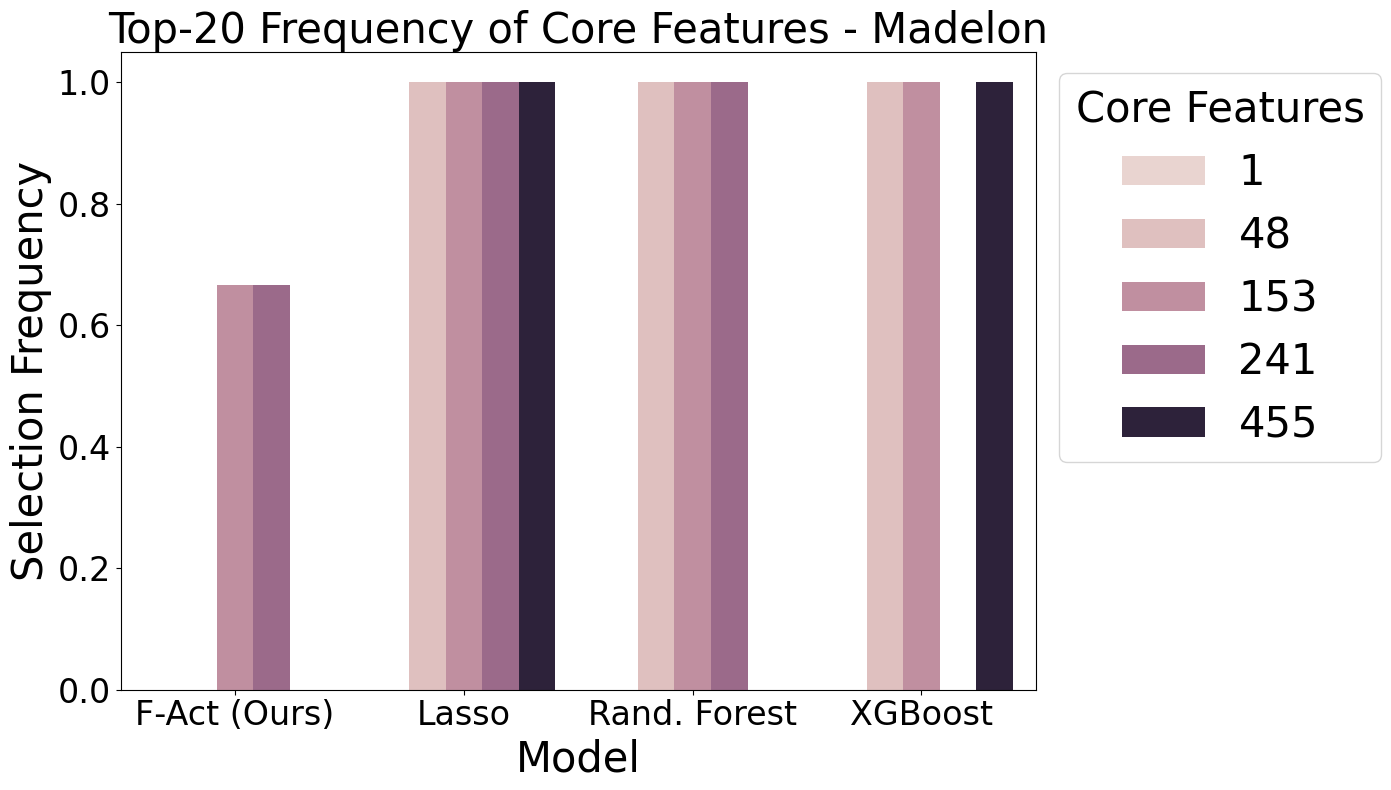

In [150]:
analysis_df = pd.concat([xgb_df, rf_df, lasso_df, madelon_df])
# Filter the DataFrame for core and dependent features
core_df = analysis_df[analysis_df['feature'].isin(core)]
dependent_df = analysis_df[analysis_df['feature'].isin(dependent)]

# Group by 'model' and 'feature' and calculate the selection frequency
core_freq = core_df.groupby(['model', 'feature'])['selected'].mean().reset_index()
dependent_freq = dependent_df.groupby(['model', 'feature'])['selected'].mean().reset_index()

# Create a figure with 2 subplots
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))  # Increased figure size

# Plot the selection frequency of core features
sns.barplot(data=core_freq, x='model', y='selected', hue='feature', ax=axes)
axes.set_title('Top-20 Frequency of Core Features - Madelon', fontsize=30)
axes.set_xlabel('Model', fontsize=30)
axes.set_ylabel('Selection Frequency', fontsize=30)
axes.tick_params(axis='both', labelsize=24)

axes.legend(
    title='Core Features', fontsize=30, title_fontsize=30, loc='upper right', bbox_to_anchor=(1.4, 1))

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure if required
plt.savefig(f'{results_dir}/madelon_core_selection_frequency.pdf')

plt.show()

66


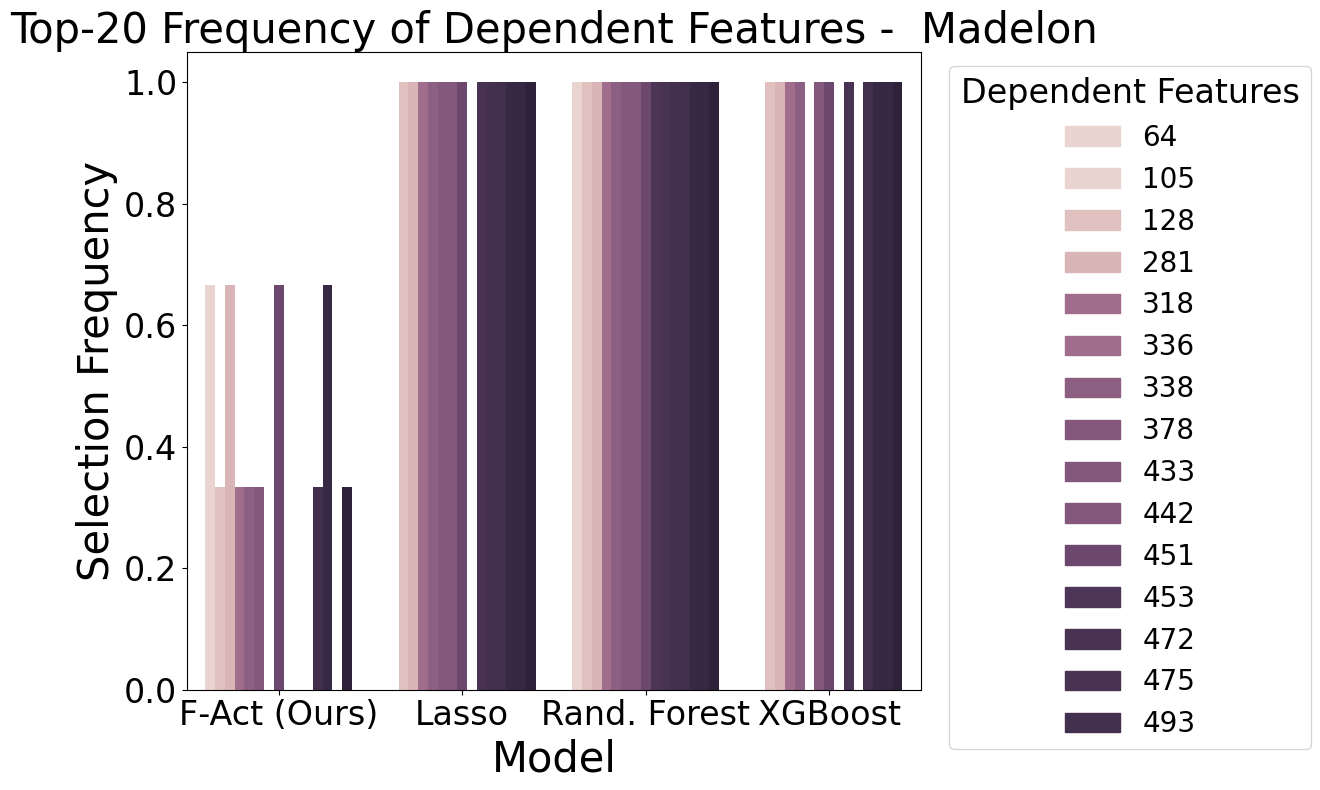

In [151]:
import matplotlib.patches as mpatches

# Create a figure with 2 subplots
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))  # Increased figure size

# Plot the selection frequency of core features
sns.barplot(data=dependent_freq, x='model', y='selected', hue='feature', ax=axes)
axes.set_title('Top-20 Frequency of Dependent Features -  Madelon', fontsize=30)
axes.set_xlabel('Model', fontsize=30)
axes.set_ylabel('Selection Frequency', fontsize=30)
axes.tick_params(axis='both', labelsize=24)

# axes.legend(
#     title='Dependent Features', fontsize=30, title_fontsize=30, loc='upper right', bbox_to_anchor=(1.4, 1))

print(len(axes.patches))

# get every 3rd patch
patches = [p for i, p in enumerate(axes.patches) if i % 3 == 0]

# Create legend manually for dependent features
# dependent_handles = [mpatches.Patch(color=p.get_facecolor(), label=label) for p, label in zip(axes.patches, dependent)]
dependent_handles = [mpatches.Patch(color=p.get_facecolor(), label=label) for p, label in zip(patches, sorted(dependent))]

axes.legend(
    handles=dependent_handles, 
    title='Dependent Features', fontsize=20, title_fontsize=24, loc='upper right', bbox_to_anchor=(1.55, 1))


# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure if required
plt.savefig(f'{results_dir}/madelon_dependent_selection_frequency.pdf')

plt.show()

In [89]:
import matplotlib.patches as mpatches

def plot_core_selection(df, core_features, dependent_features, save=False, results_dir=None):
    """
    Plot the selection frequency of core features across different models.

    Args:
        df (pd.DataFrame): The DataFrame containing 'feature', 'selected', 'model', and 'dataset'.
        core_features (list): List of 5 core features.
        dependent_features (list): List of 20 dependent features.
        save (bool): Whether to save the plot as an image file. Default is False.
        results_dir (str): Directory path to save the plot if save is True.

    Returns:
        None
    """
    # Filter the DataFrame for core and dependent features
    core_df = df[df['feature'].isin(core_features)]
    dependent_df = df[df['feature'].isin(dependent_features)]

    # Group by 'model' and 'feature' and calculate the selection frequency
    core_freq = core_df.groupby(['model', 'feature'])['selected'].mean().reset_index()
    dependent_freq = dependent_df.groupby(['model', 'feature'])['selected'].mean().reset_index()

    # Create a figure with 2 subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 12))  # Increased figure size

    # Plot the selection frequency of core features
    sns.barplot(data=core_freq, x='model', y='selected', hue='feature', ax=axes[0])
    axes[0].set_title('Top-20 Frequency of Core Features', fontsize=30)
    axes[0].set_xlabel('Model', fontsize=24)
    axes[0].set_ylabel('Selection Frequency', fontsize=24)
    axes[0].tick_params(axis='both', labelsize=24)

    axes[0].legend(
        title='Core Features', fontsize=30, title_fontsize=30, loc='upper right', bbox_to_anchor=(1.4, 1))

    # Plot the selection frequency of dependent features
    sns.barplot(data=dependent_freq, x='model', y='selected', hue='feature', ax=axes[1])
    axes[1].set_title('Top-20 Frequency of Dependent Features', fontsize=30)
    axes[1].set_xlabel('Model', fontsize=24)
    axes[1].set_ylabel('Selection Frequency', fontsize=24)
    axes[1].tick_params(axis='both', labelsize=24)

    # Create legend manually for dependent features
    # dependent_handles = [mpatches.Patch(color=p.get_facecolor(), label=label) for p, label in zip(axes[1].patches, dependent_freq['feature'].unique())]
    # axes[1].legend(
    #     handles=dependent_handles, 
    #     title='Dependent Features', fontsize=30, title_fontsize=30, loc='upper right', bbox_to_anchor=(1.55, 1))

    # Fix legend patches
    handles, labels = axes[1].get_legend_handles_labels()
    print(handles)
    axes[1].legend(handles=handles, labels=labels, title='Dependent Features', fontsize=30, title_fontsize=30, loc='upper right', bbox_to_anchor=(1.55, 1))


    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save the figure if required
    if save and results_dir:
        plt.savefig(f'{results_dir}/madelon_selection_frequency.pdf')

    plt.show()

[<matplotlib.patches.Rectangle object at 0x7342ab1ba560>, <matplotlib.patches.Rectangle object at 0x7342ab1ba500>, <matplotlib.patches.Rectangle object at 0x7342aacbbb20>, <matplotlib.patches.Rectangle object at 0x7342aacbbe50>, <matplotlib.patches.Rectangle object at 0x7342a9b34070>, <matplotlib.patches.Rectangle object at 0x7342a9b34250>]


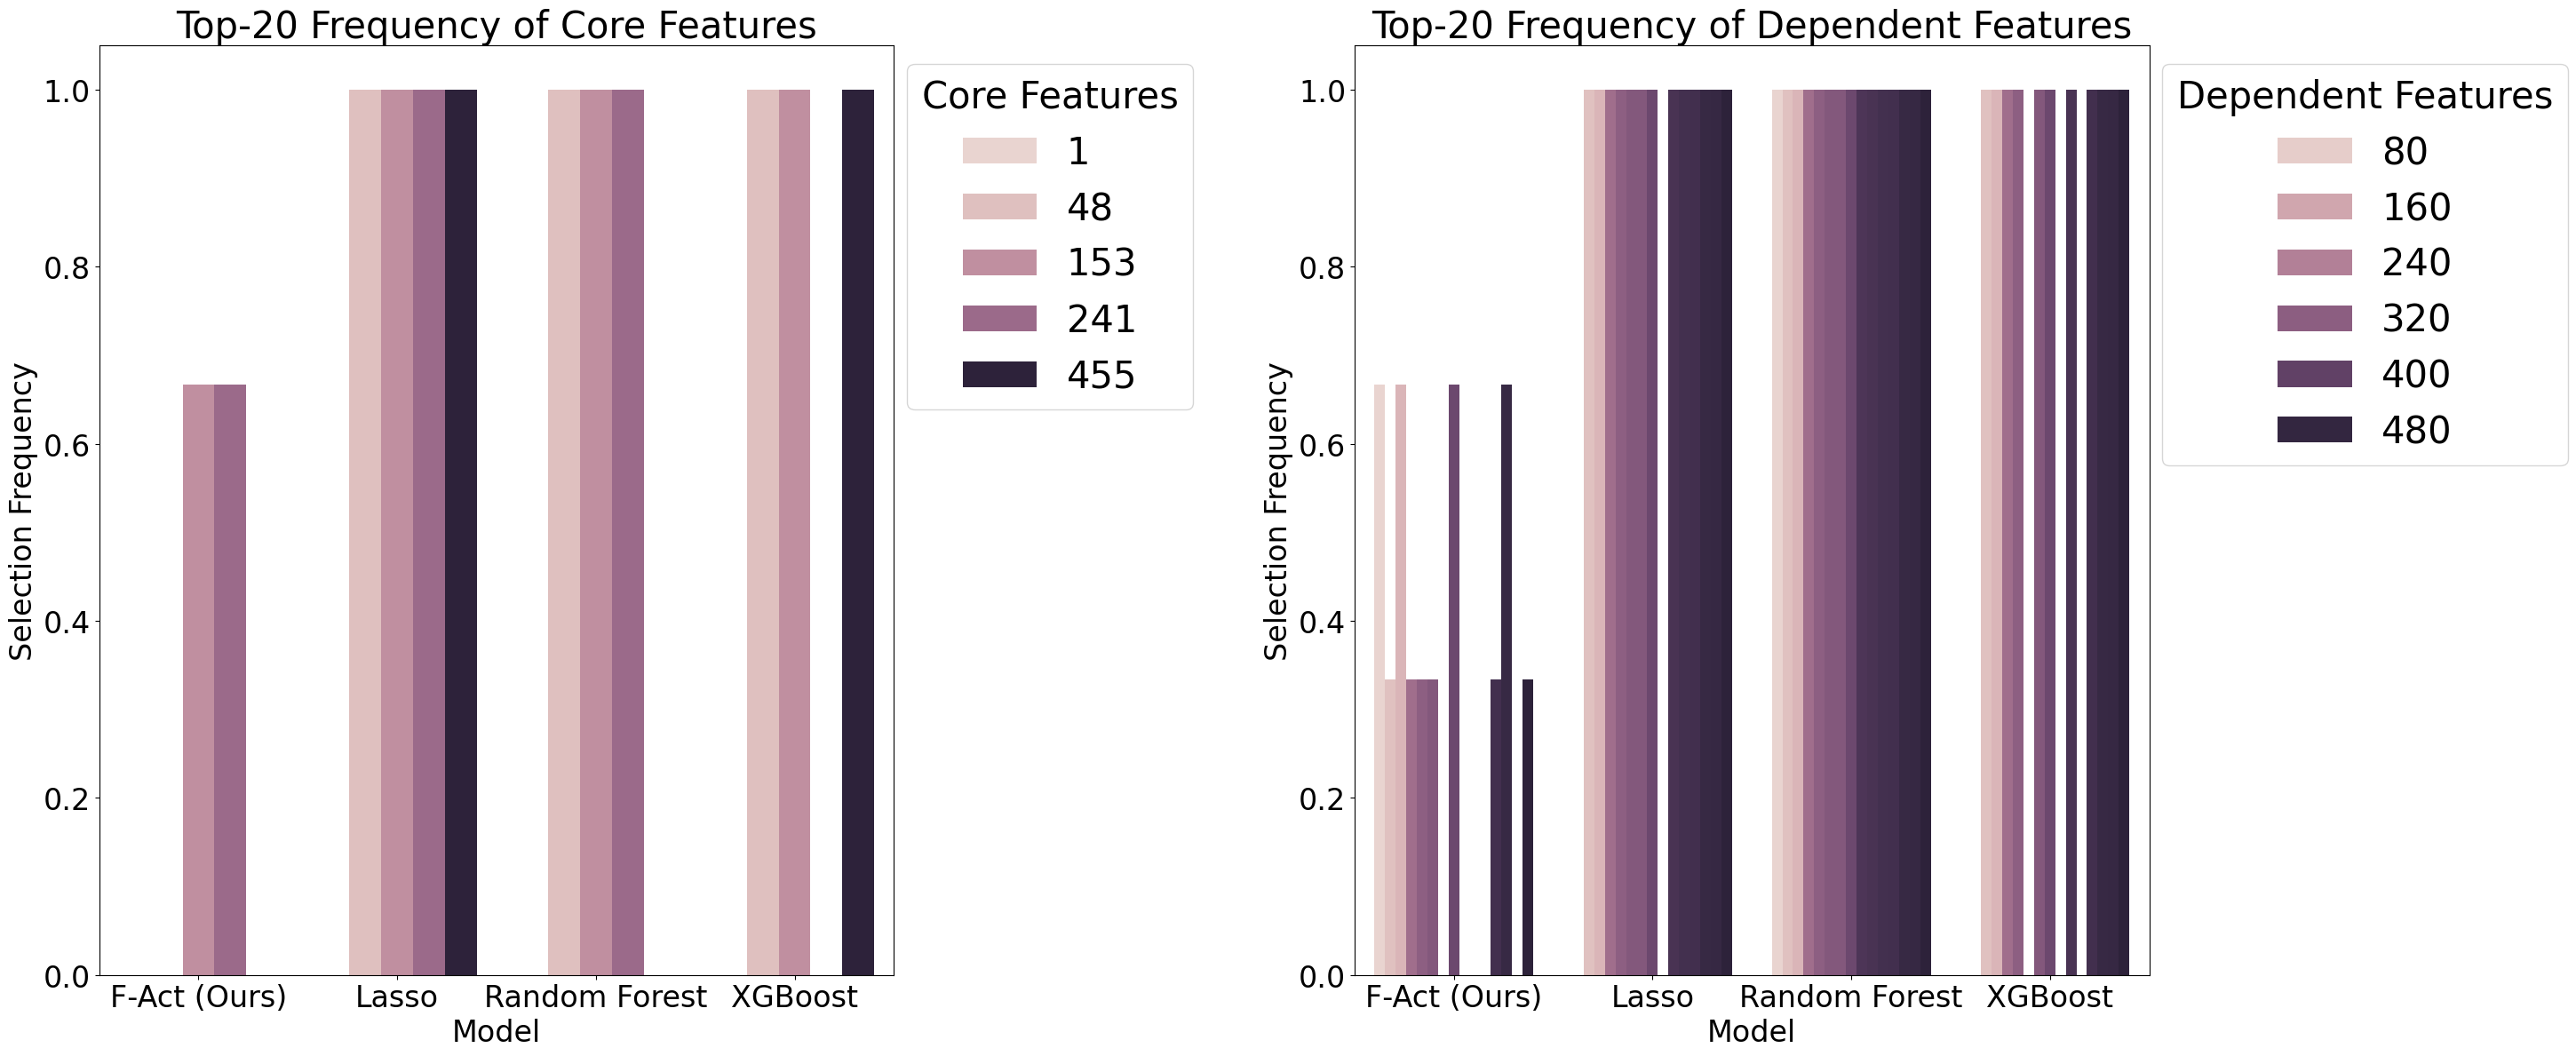

In [90]:
analysis_df = pd.concat([lasso_df, rf_df, xgb_df, madelon_df])
plot_core_selection(analysis_df, core, dependent, save=True)

In [29]:
madelon_df['selected'] = madelon_df['mask_value'] > 0   
madelon_df.groupby('run_id').sum('selected')

/tmp/ipykernel_3284740/1307746019.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  madelon_df['selected'] = madelon_df['mask_value'] > 0


,feature,mask_value,mask_0_value,mask_value_probability,mask_0_value_probability,selected
run_id,,,,,,
h4m5vvcm,124750,-741.771161,-1550.571440,104.967163,27.612638,23
ko5c4p3v,124750,-747.628839,-1546.208962,103.928551,26.224155,21
zyuohsyk,124750,-727.539527,-1295.319255,108.265197,46.921899,29


In [36]:
madelon_df['selected'] = madelon_df['mask_value'] > 0

/tmp/ipykernel_2602686/2724931081.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  madelon_df['selected'] = madelon_df['mask_value'] > 0


In [94]:
madelon_df['feature_importance'] = madelon_df['mask_0_value']

/tmp/ipykernel_2602686/2486895862.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  madelon_df['feature_importance'] = madelon_df['mask_0_value']


In [95]:
average_rank(madelon_df, core)

/tmp/ipykernel_2602686/587052005.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rank'] = df.groupby('run_id')['feature_importance'].rank(ascending=False, method='min') - 1


110.86666666666667

In [96]:
average_rank(madelon_df, dependent)


/tmp/ipykernel_2602686/587052005.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rank'] = df.groupby('run_id')['feature_importance'].rank(ascending=False, method='min') - 1


45.133333333333326

In [37]:
madelon_df[madelon_df['feature'].isin(core)]

,feature,mask_value,mask_0_value,dataset,run_id,mask_value_probability,mask_0_value_probability,selected
71950,1,-1.278299,-3.164938,madelon,ko5c4p3v,0.217840,0.040507,False
71997,48,-0.942389,-2.197245,madelon,ko5c4p3v,0.280418,0.099998,False
72102,153,0.936295,-0.859113,madelon,ko5c4p3v,0.718351,0.297525,True
72190,241,0.110704,-1.550272,madelon,ko5c4p3v,0.527648,0.175047,True
72404,455,-1.129279,-2.476467,madelon,ko5c4p3v,0.244294,0.077524,False
72450,1,-1.251465,-3.339769,madelon,h4m5vvcm,0.222447,0.034232,False
72497,48,-0.231333,-2.164849,madelon,h4m5vvcm,0.442423,0.102952,False
72602,153,1.220580,-0.595785,madelon,h4m5vvcm,0.772166,0.355309,True
72690,241,-1.139702,-2.069669,madelon,h4m5vvcm,0.242375,0.112080,False
72904,455,-0.422848,-2.195266,madelon,h4m5vvcm,0.395836,0.100176,False


In [39]:
madelon_df[madelon_df['feature'].isin(dependent)]


,feature,mask_value,mask_0_value,dataset,run_id,mask_value_probability,mask_0_value_probability,selected
72013,64,0.161112,-1.275015,madelon,ko5c4p3v,0.540191,0.218400,True
72054,105,-2.032038,-2.331058,madelon,ko5c4p3v,0.115880,0.088583,False
72077,128,1.130942,-0.716301,madelon,ko5c4p3v,0.756013,0.328208,True
72230,281,-0.015463,-1.288287,madelon,ko5c4p3v,0.496134,0.216143,False
72267,318,-2.095360,-2.952051,madelon,ko5c4p3v,0.109549,0.049640,False
72285,336,0.638077,-0.950584,madelon,ko5c4p3v,0.654319,0.278767,True
72287,338,-1.841434,-1.815263,madelon,ko5c4p3v,0.136882,0.140003,False
72327,378,-2.571586,-2.194103,madelon,ko5c4p3v,0.070990,0.100281,False
72382,433,-0.691375,-2.159862,madelon,ko5c4p3v,0.333727,0.103413,False
72391,442,-1.519509,-2.376627,madelon,ko5c4p3v,0.179534,0.084972,False


In [100]:
madelon_df[~madelon_df['feature'].isin(core+dependent)].groupby('run_id')['selected'].sum().mean()


17.666666666666668

In [101]:
madelon_df.groupby('run_id')['selected'].sum().mean()


24.333333333333332

In [ ]:
madelon_df[madelon_df['feature'].isin(core+dependent)]['selected'].sum()


In [23]:
def calculate_selection_percentage(df, features):
    percentages = {}
    for feature in features:
        # Filter DataFrame for each individual feature
        feature_df = df[df['feature'] == feature]
        # Check if there are any rows for this feature
        if not feature_df.empty:
            # Calculate the percentage of 'True' in the 'selected' column
            selected_percentage = (feature_df['selected'].sum() / len(feature_df)) * 100
        else:
            selected_percentage = 0  # No data for this feature in the DataFrame
        percentages[feature] = selected_percentage
    return percentages

In [38]:
for run_id in madelon_df['run_id'].unique():
    run_df = madelon_df[madelon_df['run_id'] == run_id]
    percentages = calculate_selection_percentage(run_df, core)
    print(f"Run ID: {run_id}")
    print(f"Core features selection percentages: {percentages}")
    print(f"dependent features selection percentages: {calculate_selection_percentage(run_df, dependent)}")
    print()

Run ID: ko5c4p3v
Core features selection percentages: {153: 100.0, 455: 0.0, 241: 100.0, 48: 0.0, 1: 0.0}
dependent features selection percentages: {281: 0.0, 433: 0.0, 318: 0.0, 451: 0.0, 378: 0.0, 475: 0.0, 453: 0.0, 493: 0.0, 338: 0.0, 472: 100.0, 442: 0.0, 105: 0.0, 128: 100.0, 336: 100.0, 64: 100.0}

Run ID: h4m5vvcm
Core features selection percentages: {153: 100.0, 455: 0.0, 241: 0.0, 48: 0.0, 1: 0.0}
dependent features selection percentages: {281: 100.0, 433: 0.0, 318: 0.0, 451: 0.0, 378: 100.0, 475: 0.0, 453: 0.0, 493: 100.0, 338: 0.0, 472: 100.0, 442: 0.0, 105: 100.0, 128: 100.0, 336: 0.0, 64: 0.0}

Run ID: zyuohsyk
Core features selection percentages: {153: 0.0, 455: 0.0, 241: 100.0, 48: 0.0, 1: 0.0}
dependent features selection percentages: {281: 100.0, 433: 0.0, 318: 100.0, 451: 0.0, 378: 100.0, 475: 0.0, 453: 100.0, 493: 0.0, 338: 0.0, 472: 100.0, 442: 0.0, 105: 0.0, 128: 0.0, 336: 0.0, 64: 100.0}



In [30]:
calculate_selection_percentage(madelon_df, core)

{153: 66.66666666666666, 455: 0.0, 241: 66.66666666666666, 48: 0.0, 1: 0.0}

In [31]:
calculate_selection_percentage(madelon_df, dependent)


{281: 66.66666666666666,
 433: 0.0,
 318: 33.33333333333333,
 451: 0.0,
 378: 66.66666666666666,
 475: 0.0,
 453: 33.33333333333333,
 493: 33.33333333333333,
 338: 0.0,
 472: 100.0,
 442: 0.0,
 105: 33.33333333333333,
 128: 66.66666666666666,
 336: 33.33333333333333,
 64: 66.66666666666666}

In [20]:
madelon_df.head()

,feature,mask_value,mask_0_value,dataset,mask_value_probability,mask_0_value_probability,selected
71949,0,-1.427203,-3.598731,madelon,0.193535,0.026630,False
71950,1,-1.278299,-3.164938,madelon,0.217840,0.040507,False
71951,2,1.198822,-1.621450,madelon,0.768315,0.165005,True
71952,3,-0.523786,-2.869547,madelon,0.371967,0.053680,False
71953,4,-1.032853,-2.948297,madelon,0.262531,0.049817,False


# idk other i guess?

In [7]:
def combine_histograms(histograms):
    # Determine the overall range of bins
    min_bin = min(hist['bins'][0] for hist in histograms)
    max_bin = max(hist['bins'][-1] for hist in histograms)
    
    # Create a new set of bins, here using the minimum and maximum with a dynamic bin width based on the input histograms
    # For simplicity, we'll use a fixed number of bins, but this could be adapted
    num_bins = 50
    new_bins = np.linspace(min_bin, max_bin, num_bins)
    
    # Initialize an array to hold the combined counts
    combined_counts = np.zeros(len(new_bins) - 1)
    
    # Process each histogram
    for hist in histograms:
        # For each old bin, find the closest new bin and add the counts
        for i, count in enumerate(hist['values']):
            # Find the center of the current old bin
            old_bin_center = (hist['bins'][i] + hist['bins'][i + 1]) / 2
            
            # Find the index of the closest new bin
            new_bin_index = np.argmin(np.abs(new_bins - old_bin_center))
            
            # Check if this assignment overshoots the array bounds
            if new_bin_index == len(combined_counts):
                new_bin_index -= 1
            
            # Add the count to the closest new bin
            combined_counts[new_bin_index] += count
    
    return new_bins, combined_counts

from itertools import combinations

def hamming_distance(s1, s2):
    """Calculate the Hamming distance between two strings."""
    assert len(s1) == len(s2), "Strings must be of the same length"
    return sum(el1 != el2 for el1, el2 in zip(s1, s2))

def normalized_average_hamming_distance(strings, inverse=False):
    """Calculate the normalized average Hamming distance for a list of strings."""
    if len(strings) < 2:
        return 0  # No distance if there's only one string
    
    distances = [hamming_distance(s1, s2) for s1, s2 in combinations(strings, 2)]
    if inverse:
        zero_counts = [s.count("1") for s in strings]
    else:
        zero_counts = [s.count("0") for s in strings]
    average_distance = sum(distances) / len(distances)
    return average_distance / sum(zero_counts) # Normalize by average number of masked features

def get_agreement(mask_dict, inverse=False):
    # Get the agreement between the masks
    df_dict = {'dataset': [], 'normalized_distances': [], 'avg_num_masked_features': [], 'num_features': []}
    for key, value in mask_dict.items():
        df_dict['dataset'].append(key)
        df_dict['normalized_distances'].append(normalized_average_hamming_distance(value, inverse=inverse))
        if inverse:
            df_dict['avg_num_masked_features'].append(np.mean([s.count("1") for s in value]))
        else:
            df_dict['avg_num_masked_features'].append(np.mean([s.count("0") for s in value]))
        df_dict['num_features'].append(len(value[0]))
    
    # Convert to DataFrame
    df = pd.DataFrame.from_dict(df_dict)

    # Subtract each value from 1
    df['Mask stability'] = 1 - df['normalized_distances']
    df.drop(columns=['normalized_distances'], inplace=True)
    
    df['masked_feat_fraction'] = df['avg_num_masked_features'] / df['num_features']

    # Pretty print the DataFrame
    return df.style.set_table_styles(
        [{'selector': 'th', 'props': [('background', '#606060'), ('color', 'white')]}]
    ).set_caption("Mask stability across multiple seeds")



In [8]:
get_agreement(mask_dict)

,dataset,avg_num_masked_features,num_features,Mask stability,masked_feat_fraction
0,finance,117.333333,154,0.835227,0.761905
1,USPS,188.000000,256,0.813239,0.734375
2,madelon,475.666667,500,0.971969,0.951333
3,Isolet,518.000000,617,0.897469,0.839546
4,COIL20,866.000000,1024,0.898127,0.845703
5,mice_protein,47.333333,77,0.821596,0.614719
6,poly_binarised_decimalised_synth,8.000000,10,0.833333,0.800000


In [9]:
mask_dict_1 = {key: val for key, val in mask_dict.items() if key != 'poly_binarised_decimalised_synth'}

get_agreement(mask_dict_1, inverse=True)


,dataset,avg_num_masked_features,num_features,Mask stability,masked_feat_fraction
0,finance,36.666667,154,0.472727,0.238095
1,USPS,68.000000,256,0.483660,0.265625
2,madelon,24.333333,500,0.452055,0.048667
3,Isolet,99.000000,617,0.463524,0.160454
4,COIL20,158.000000,1024,0.441632,0.154297
5,mice_protein,29.666667,77,0.715356,0.385281


In [10]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def plot_histograms(hist_dict, threshold_line=None, sigmoid_x=False):
    # Determine the layout of the subplots
    nrows = int(len(hist_dict)**0.5)  # Square root of the number of datasets for rows
    ncols = int(len(hist_dict) / nrows) + (len(hist_dict) % nrows > 0)  # Adjust columns accordingly

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*4))  # Adjust figsize for landscape layout
    fig.tight_layout(pad=3.0)  # Add some padding between plots

    for ax, (dataset, histograms) in zip(axs.flatten(), hist_dict.items()):
        try:
            bins, values = combine_histograms(histograms)
        except Exception as e:
            print(f"Error combining histograms for {dataset}: {e}")
            continue
        
        # Normalize the values by number of histograms
        values /= len(histograms)
        
        # Apply sigmoid transformation if needed
        if sigmoid_x:
            # Use original bins to calculate values at transformed bins
            transformed_bins = sigmoid(bins)
            bin_edges = np.histogram_bin_edges(bins, bins=transformed_bins)
            values, _ = np.histogram(bins[:-1], bins=bin_edges, weights=values)
            bin_centers = (transformed_bins[:-1] + transformed_bins[1:]) / 2
            bin_widths = np.diff(transformed_bins)
        else:
            # Calculate bin widths and bin centers as usual
            bin_widths = np.diff(bins)
            bin_centers = (bins[:-1] + bins[1:]) / 2

        # Plotting on the specific subplot axis
        ax.bar(bin_centers, values, width=bin_widths, align='center', edgecolor='black')
        ax.set_xlabel('Bin (Transformed)' if sigmoid_x else 'Bin')
        ax.set_ylabel('Count')
        if threshold_line is not None:
            # Transform threshold line if sigmoid is applied
            transformed_threshold = sigmoid(threshold_line) if sigmoid_x else threshold_line
            ax.axvline(x=transformed_threshold, color='red', linestyle='--')
        ax.set_title(f'{dataset} Histogram')

    # Adjust if the number of datasets is not a perfect square to hide empty subplots
    for ax in axs.flatten()[len(hist_dict):]:
        ax.set_visible(False)

    plt.show()


In [15]:
y = 0.1
x = np.log(y / (1 - y))
x

-2.197224577336219

In [17]:
sigmoid = lambda x  : 1 / (1 + np.exp(-x))
for val in [-5, -2, -1, 0, 1, 2, 5]:
    print(f"sigmoid({val}) = {sigmoid(val)}")

sigmoid(-5) = 0.0066928509242848554
sigmoid(-2) = 0.11920292202211755
sigmoid(-1) = 0.2689414213699951
sigmoid(0) = 0.5
sigmoid(1) = 0.7310585786300049
sigmoid(2) = 0.8807970779778825
sigmoid(5) = 0.9933071490757153


Error combining histograms for poly_binarised_decimalised_synth: list indices must be integers or slices, not str


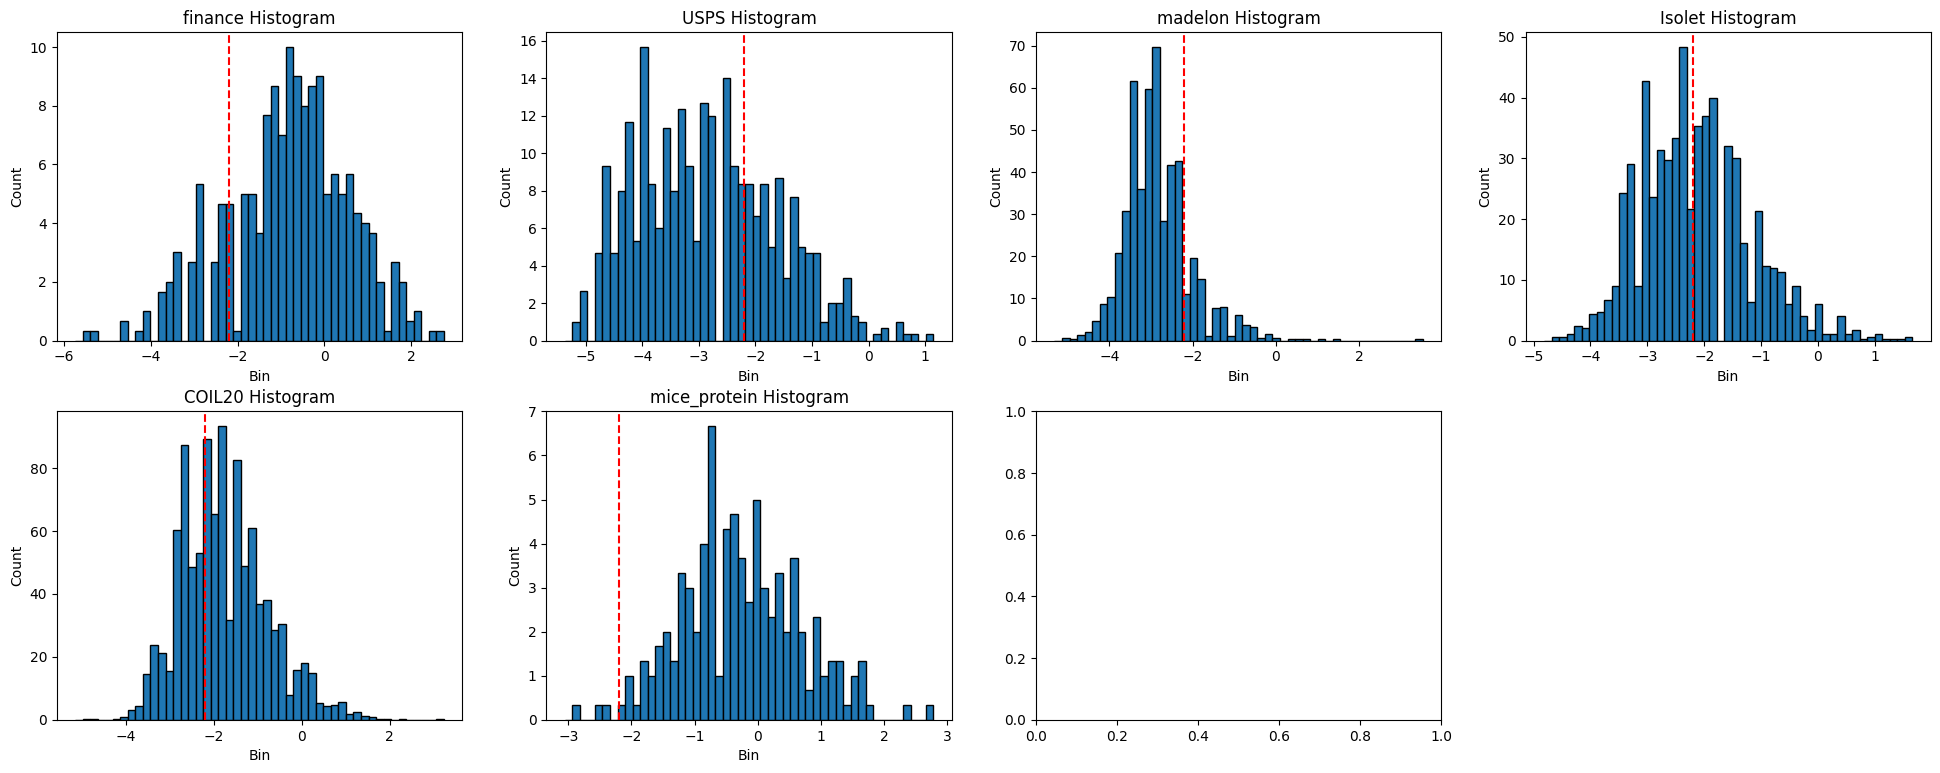

In [16]:
plot_histograms(hist_0_dict, threshold_line=-2.197224577336219)

Error combining histograms for poly_binarised_decimalised_synth: list indices must be integers or slices, not str


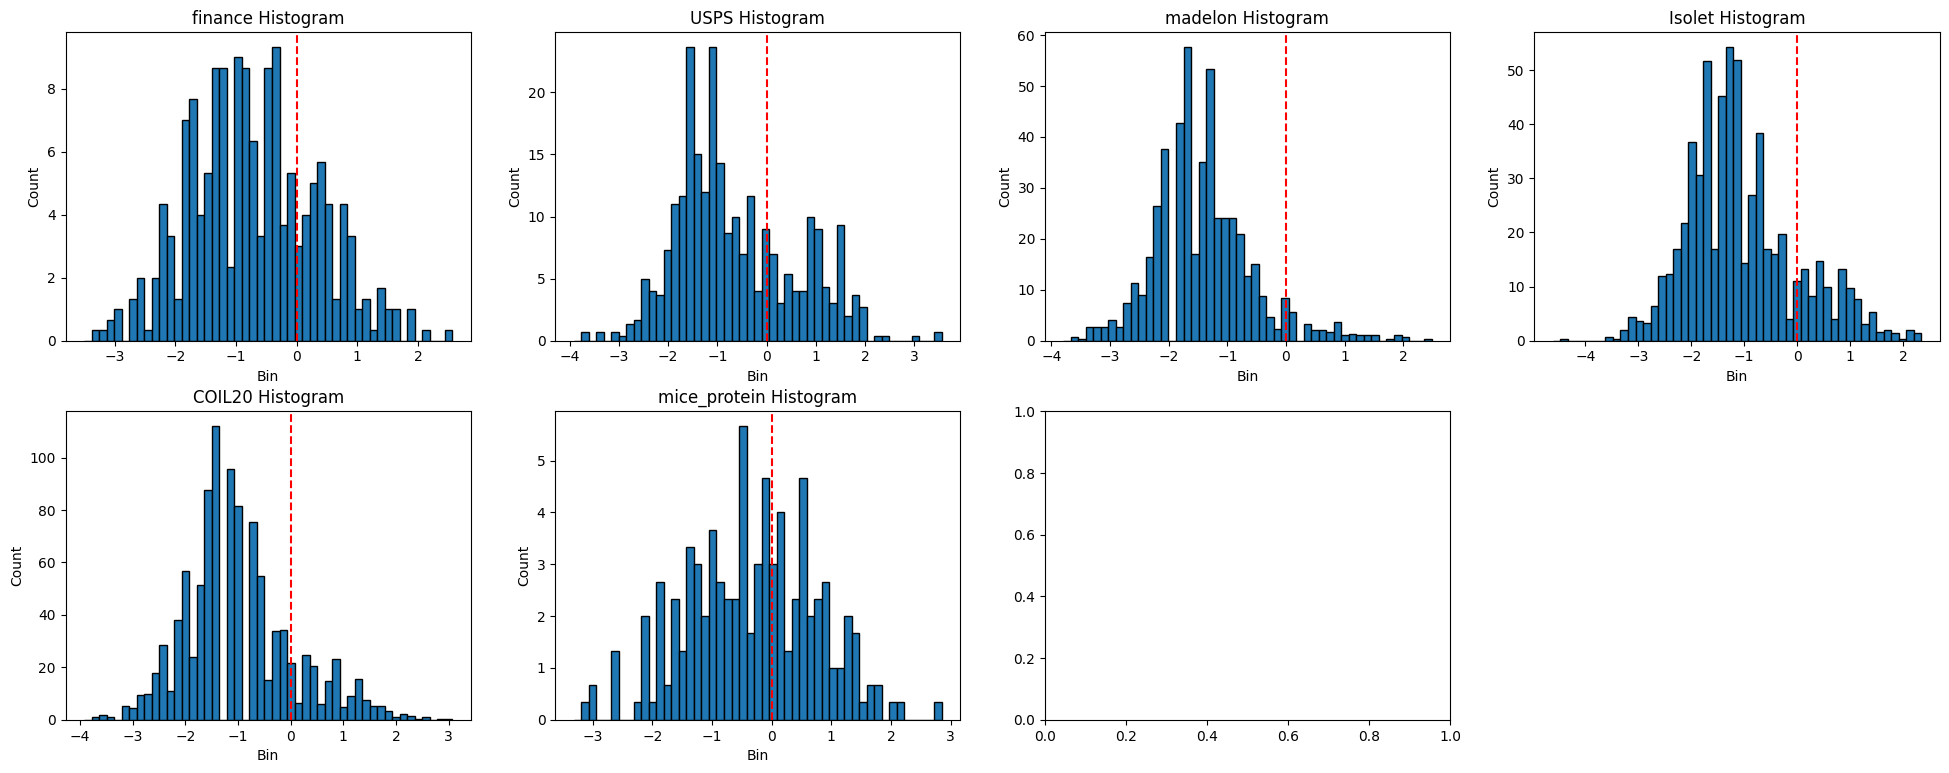

In [12]:
plot_histograms(hist_1_dict, threshold_line=0)

In [13]:
hist = run.summary['best_mask_parameters']

KeyError: 'best_mask_parameters'

In [ ]:
a = np.array(hist['values'])
b = a
np.vstack((a,b)).mean(axis=0).shape

(32,)

In [ ]:
hist

{'values': [1, 0, 1, 0, 0, 0, 0, 1, 0, 2, 3, 4, 3, 10, 18, 15, 37, 32, 40, 50, 59, 59, 44, 30, 32, 21, 11, 14, 2, 4, 5, 2], 'bins': [-2.3778932094573975, -2.191999673843384, -2.006105899810791, -1.8202123641967773, -1.6343187093734741, -1.448425054550171, -1.2625313997268677, -1.0766377449035645, -0.890744149684906, -0.7048504948616028, -0.5189568996429443, -0.3330632448196411, -0.14716961979866028, 0.038724012672901154, 0.22461764514446259, 0.4105112850666046, 0.5964049100875854, 0.7822985649108887, 0.9681921601295471, 1.1540857553482056, 1.3399794101715088, 1.525873064994812, 1.7117667198181152, 1.8976603746414185, 2.0835540294647217, 2.2694475650787354, 2.455341339111328, 2.641234874725342, 2.8271284103393555, 3.0130221843719482, 3.198915719985962, 3.3848094940185547, 3.5707030296325684], '_type': 'histogram'}

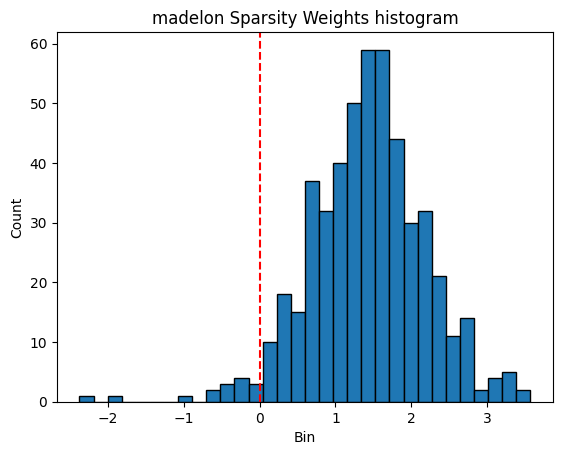

In [ ]:

# Histogram data
values = hist['values']
bins = hist['bins']

# Calculate bin widths and bin centers
bin_widths = [j - i for i, j in zip(bins[:-1], bins[1:])]
bin_centers = [(i + j) / 2 for i, j in zip(bins[:-1], bins[1:])]

# Plotting
plt.bar(bin_centers, values, width=bin_widths, align='center', edgecolor='black')
plt.xlabel('Bin')
plt.ylabel('Count')
plt.axvline(x=0, color='red', linestyle='--')

plt.title(f'{dataset} Sparsity Weights histogram')
plt.show()


In [ ]:
# Initialize a list to store data
data = []

# Iterate over each run and fetch the required data
for run in sweep.runs:
    config = run.config
    summary_metrics = run.summary
    # You might need to adjust the key names based on your actual data
    try:
        data.append({
            'dataset': config['dataset'],  
            'seed_model_init': config['seed_model_init'], 
            # Add other hyperparameters here as needed
            'normalize_reconstruction': config['normalize_reconstruction'],  
            'balanced_accuracy': summary_metrics['bestmodel_valid/balanced_accuracy'],  # Adjust based on your summary metrics
            # Include other config elements as necessary
        })
    except:
        print(f"Run {run.id} failed")

# Convert the list to a DataFrame
df = pd.DataFrame(data)

df = df[df['dataset'] != 'poly_binarised_decimalised_mod10_synth'] # excliude this dataset

# Group by dataset and other relevant hyperparameters (excluding seed), and calculate the mean of balanced_accuracy across seeds
grouped_df = df.groupby(['dataset', 
                         'normalize_reconstruction'  # Add other hyperparameters here, except 'seed'
                        ]).agg({'balanced_accuracy': 'mean'}).reset_index()

# Now, find the entry with the maximum 'balanced_accuracy' for each 'dataset'
result_df = grouped_df.loc[grouped_df.groupby('dataset')['balanced_accuracy'].idxmax()]

# Display the resulting DataFrame
print(result_df)


Run x5mlx25b failed
Run 6y520ck9 failed
Run fa1xfouk failed
Run 1691mmmr failed
             dataset normalize_reconstruction  balanced_accuracy
0              MNIST  num_non_masked_features           0.980751
2  simple_trig_synth             num_features           0.979334


In [ ]:
print(grouped_df)

             dataset normalize_reconstruction  balanced_accuracy
0              MNIST  num_non_masked_features           0.980751
1  simple_trig_synth                     None           0.975825
2  simple_trig_synth             num_features           0.979334
3  simple_trig_synth  num_non_masked_features           0.978480
